ОТЧЁТ:
В данном проекте было необходимо создать модель по прогнозированию оттока клиентов для компании «Ниединогоразрыва.ком».

1. В нашем распоряжении было четыре датасета: 

данные о контрактах (df_contract), содержащие такие столбцы, как:

    * customerID - ID клиента
    * BeginDate  - дата начала пользования услугами
    * EndDate    - дата окончания пользования услугами 
    * Type       - тип контракта
    * PaperlessBilling - (вероятно) вариант предоставления счета - бумажные или нет
    * PaymentMethod - способ оплаты
    * MonthlyCharges - ежемесячный платеж
    * TotalCharges - общая сумма платежей
    
данные о клиентах (df_person):

    * customerID - ID клиента
    * gender  - пол клиента
    * SeniorCitizen - пенсионер или нет
    * Partner  - наличие гражданского мужа/жены
    * Dependents - есть ли кто-то на иждивении 
    
данные о подключённых интернет услугах (df_internet):

    * customerID - ID клиента
    * InternetService  - технология доступа в интернет
    * OnlineSecurity - доп. услуга 
    * OnlineBackup   - доп. услуга 
    * DeviceProtection - доп. услуга 
    * TechSupport - доп. услуга 
    * StreamingTV - доп. услуга 
    * StreamingMovies - доп. услуга 
    
данные о телефонии (df_phone):

    * customerID - ID клиента
    * MultipleLines  - возможность многоканальных звонков

Все четыре таблицы были объединены по идентификатору клиента внешним образом. Получившиеся пропуски в столбце ‘MultipleLines ’ были заполнены значением ‘Unknown’ - факт того, что клиент не пользуется телефонией. Пропуски в столбцах, относящихся к интернету были заменены на ‘No’.

Целевой признак был выделен из таблицы df_contract, как факт ухода клиента (‘churn’): 0 если в столбце EndDate не стоит даты ухода и 1 если дата ухода есть.

Также был создан новый столбец - ‘days’ - длительность контракта в днях. Данный столбец был получен как разность между датой завершения контракта, если таковая есть, или 1 февраля 2020 года (дата выгрузки данных) и датой начала. 

2. Далее был проведён исследовательский анализ данных:

- столбцы приведены к змеиному регистру;
- было найдено и удалено 11 пропусков в столбце ‘total_charges’;
- типы столбцов, содержащих количественные данные, были заменены на float;
- выбросов в данных в столбцах ‘total_charges’ и ‘monthly_charges’ обнаружено не было;
- но было отмечено, что среднее значение платежа у ушедших больше. Также можно отметить, что у оставшихся разброс значений платежа большой, в то время, как у ушедщих значения ежемесячного платежа более компактны. 
- с помощью библиотеки Sweetwiz был создан отчёт о взаимозависимости данных, 
-  cтолбцы, относящиеся к датам (EndDate и BeginDate), а также ‘Total_Charges’ были удалены из итогового датафрейма во избежание улички данных.
- дубликаты в количестве 23 штук были удалены.

Всего на этом этапе в итоговом датафрейме - 7009 строк и 18 столбцов. 

3. Была проведена предобработка данных перед обучением:

- категориальные признаки были кодированы с помощью OHE (Ordinal Encoder в нашем случае не подходит, тк в обучении предполагается использовать линейные модели),
- данные были разделены на фичи и таргет;
- было произведено разбиение на обучающую и тестовую выборки в отношении 4:1 с использованием параметра stratify для сбалансированности классов;
- масштабирование признаков производилось с использованием StandardScaler.  RobustScaler и MinMaxScaler для нашей задачи не подходили;
- проверка признаков на наличие корреляции производилась с использованием коэффициента Phik. Были найдены корреляции между признаками и некоторые признаками были удалено в первой версии. После рекомендации ревьюера все категориальные признаки были оставлены. 

Всего на этом этапе в итоговом датафрейме - 7009 строк и 22 столбца. 

4. Для обучения были использованы следующие ML модели: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, XGBClassifier, а также поверх плана была идея использовать две другие модели  GradientBoostingClassifier и MLPClassifier. 
Однако GradientBoostingClassifier работал крайне долго, а результаты показывал средние, что касается MLPClassifier, то, к сожалению, не удалось правильно настроить модель .
- поиск лучших гиперпараметров моделей осуществлялся с помощью RandomizedSearchCV;
- в качестве скоринга рассчитывались метрики: ROC-AUC, accuracy, f1, precision, recall. Первая определялась как наиболее важная;
- по результатам обучения моделей была создана сводная таблица, содержащая значения  метрик и наилучшие параметры моделей, время обучения моделей. 
- наилучший результат  ROC-AUC = 0.9195 показала модель LGBM.
- был построен соответствующий график вместе с графиком базовой модели;
- была построена гистограмма важности признаков, наиболее важными оказались ‘days’ и ‘monthlt_charges’. 

6.  Эксперимент 1:

В качестве эксперимента было решено удалить большинство неважных для модели признаков и оставить лишь 6 наиболее важных: 'monthly_charges', 'days', 'paperless_billing_Yes', 'tech_support_Yes',  'multiple_lines_Yes', 'type_One year'. 

   - была произведена необходимая подготовка данных и модель LGBM была обучена еще раз на новых данных.
   - получили метрику чуть выше, чем было! ROC-AUC = 0.9239
   
Эксперимент 2: 

- оставили только два самых важных признака: 'monthly_charges' и 'days' и снова обучили модель;
- получили метрику чуть-чуть хуже, чем с 6 признаками, но лучше, чем с 22 признаками. ROC-AUC = 0.9232

Получается, что с двумя признаками модель работает немного хуже, чем с шестью, но даже чуть лучше, чем с 22 признаками. Много признаков создают шум. 

Что не получилось:
- две новые модели были добавлены не удачно
- провалилась идея с тспользованием RobustScaler. StandardScaler работал лучше
- не удалось настроить Optuna для более быстрого поиска гиперпараметров


Вывод:

Таким образом, типичный портрет уходящего клиента таков: 

-  Он пришел к пройвайдеру в последние несколько лет.
-  Он пользуется интернетом. 
-  Интернетом он пользуется по оптоволокну.
-  По мимо интернета он также пользуется телефонией с возможностью многоканальных звонков. 
-  Вариативность оказываемых услуг для клиента не важна, важна лишь стоимость. 

Если зацепить клиента на некоторый срок у провайдера, то вероятность его ухода снижается. Получается, что как раз для новеньких клиентов очень актуально устраивать акции и сперпредложения с целью удержания. 


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
<br />
Антонина, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
    <p><u><b> ОТВЕТ СТУДЕНТА 2</b></u></p> Спасибо, Николай! Если ты тот самый Николай, с которым мы два раза уже встречались, то мне прям повезло, очень, всегда кайфую от твоей работы над моей работой =)) ! 
    Спасибо тебе большое!
    
    Добавила в проект:
    
    1. Стат тест по проверке среднего двух совокупностей
    2. Ящики с усами на одном графике, спасибо тебе
    3. Не стала удалять никакие категориальные признаки
    4. Масштабировала только количественные
    5. Воспользовалась твоей функцией АУК, подправила неработающие там моменты, но все равно по ней остались вопросы, пожалуйста посмотри. 
    6. Скор получился такой же (тк ранее удаленные категориальные признаки почти не важны)
    7. Посчитала полноту и точность также
    8. Сделала график важности признаков побольше )))
    9. Убрала неважные признаки и обучила лучшую модель еще раз.
    10. Получила метрику чуть выше, чем было. 
    11. Оставила только два самых важных признака: 'monthly_charges' и 'days' и снова обучила модель.
    12. Получила метрику чуть хуже, чем с 6 признаками, но лучше, чем с 22 признаками.
    13. Сделала новые выводы
    
Все это я прокомментировла КОММЕНТАРИЙ СТУДЕНТА 2 В СИНИХ ЯЧЕЙКАХ
    
    
<br>

In [116]:
## Прогнозирование оттока клиентов телеком компании

### Дорогой ревьюер!

Заранее очень признательна за твою проверку моего проекта, тут много в чем надо разбираться и чем дальше я учусь, тем больше понимаю, сколько всего не знаю, и сколько всего еще можно раскапывать дальше в сфере DS, но мне безумно нравится!

Походу проекта, я оставляла вопросы к тебе в синих ячейках, а также вопросы здесь:

1. При использовании признака длительность контракта в днях (days) значительно повышается метрика - 0.89, а на тесте даже больше. Если убрать столбец days, то roc_auc максимум 0.85. на трейне и 0.82 на тесте. Насколько корректно вообще добавлять этот столбец? ведь у новых клиентов там будут минимальные значения и модель будет думать, что они вот вот уйдут. Но это может не соответствовать действительности.
В итоге days я оставила, но удалила все даты и общие платежи (по сути общие платежи тоже показывают срок жизни клиента), ведь на самом деле данные о длительности контракта могут обновляться, скажем, раз в два месяца, и для новых клиентов тоже...

Если метрики 0.88 для оценки в 6 баллов надо добиться без столбца days, то тогда прошу наводку! Ооочень хочу разобраться, как это возможно сделать без этого признака. 

2. На внебинаре нам говорили, что имеет смысл для масштабирования использовать robustscaler, однако мне показалось, что StandartScaler работает лучше всего. А хуже всего robustscaler. Или я что-то не так делаю? Если будет возмодность - взглни, пожалуйста. Ячейка 125.
3. Я же правильно понимаю, корреляцию с Phik можно применять и для количественных и для категориальных переменных одновременно? Или надо для количественных еще и корреляцию Пирсона смотреть?
4. Напомни, пожалуйста, после получения коэффициентов корреляции, каким инструментом проверить достоверность данных?
5. Не получается использовать pandas_profiling. Это только со мной что-то не так? =)
6. Смысловой вопрос: на EDA как правило тратится много времени. Одно дело, если есть пропуски, выбросы и тд - это может мешать модели нормально обучаться, но если всего этого нет, как в нашем случае, то правильно ли я понимаю, что проведение EDA это просто доп информация для нас, построение портрета уходящего клиента и тд. Хороший EDA никак не повлияет на обучение моделей (помимо выбросов, пропусков, добавления/удаления столбцов)??
7. В итоге в прокте помимо выше озвученных, попробовала использовать GradientBoostingClassifier - удачно. 
И MLPClassifier - не удачно (ругается, но пока не могу разобраться в чем дело). Какие еще модели ты бы посоветовал попробовать и изучить?


Буду ОЧЕНЬ ПРИЗНАТЕЛЬНА, если у тебя будет возможность на них ответить и помочь мне разобраться! Заранее благодарю!

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
Отличный арсенальчик вопросов:)<br>
Сначала пройдусь до конца, пото вернусь...

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
2) Ответил в тексте.<br>
3) Библиотека сама по себе ещё новая... Для себя пользуюсь по классике: СПИРМЕН/ПИРСОН для коичественных (и только для них разруливую мультиколлинеарность). Для категориальных не считаю. Если надо их сравнить - тиспользую Хи_квадрат. Новая библиотека тоже всё это использует. Только в атоматизированном и чуть изменнёном виде.<br>
4) расчёт p-уровня (уровнеь достоверности)<br>
5) Написал в тексте.<br>
6) Верно. Но это ведь база-база. Если данные норм - результат модели тоже норм. Ещё, помимо выбросов, пропусков..., можно смотреть так называему адекватность данных самому бизнес процессу, который моделируем. На этих данных сходу не придумаю. В домене промышленность твои коллеги как раз могут этопосмотреть. Там единицей моделирования является ковш с металом ( у нас клиент). И там может быть ситуация, когда с выбросами и пропусками всё норм. Но данные не подходят для моделирования. Т.е. будут недостоверны именно для описываемого процесса. Вот придумал (дурацкий примре правда..) к нашим данным. Предположим, есть столбец, в ккотором указано название компании-заказчика. И вдруг попались клиенты, у которых в этом столбце - иная компания (не спрашивай меня как)) И тогда такие клиенты не подойдут нам, даже если данные качественные. Как-то так)<br>
7) У тебя и так большой список моделей, основные ты перепробовала. Дальше моно просто - ввести в инте "все модели машинного обучкения" и пробовать их. Практика показывает, что когда много категориальных данных, то кэтбуст хорошо работает. <br>
    
Остальное - по тексту.

### Описание задачи

Необходимо создать модель по прогнозированию оттока клиентов для компании «Ниединогоразрыва.ком». В случае, если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 
По собранным данным о некоторых клиентах, информации об их тарифах и договорах необходимо обучить модели для прогнозирования факта ухода клиента. 

### План работы

1. Просмотр исходных данных о клиентах и их контрактах, состоящих из четырех датасетов. 

2. Исследовательсикй анализ данных: 
    - приведение столбцов к змеиному регистру, 
    - просмотр на наличие пропусков в данных и выбросов,
    - добавление новых столбов при необходимости, 
    - изменение типов данных, 
    - просмотр распределения данных, 
    - удаление столбцов, не несущих смысловую нагрузку,
    - склеивание всех таблиц в единую таблицу.
    
3. Предобработка данных перед обучением:
    - кодирование категориальных признаков,
    - разделение данных на фичи и таргет (классы должны быть сбалансированы),   
    - разбиение на обучающую и тестовую выборки,
    - масштабирование фичей,
    - проверить признаки на наличие корреляции.
    
4. Обучение моделей: 
    - использование следующих ML моделей: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, XGBClassifier
    - поиск лучших гиперпараметров моделей с помощью RandomizedSearchCV либо GridSearchCV.
    
5. Проверка лучших моделей на тестовой выборке:
    - сравнение полученных результатов с базовой моделью,
    - построение таблиц важности признаков.
6. Выводы

### Описание нюансов

1. В качестве оценки качества моделей предполагается использовать метрики: Accuracy, AUC-ROC, построение ROC кривой 
2. Предполагается использование следующих ML моделей: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, XGBClassifier
3. С целью экономии памяти предполагается сначала "обработать" каждый датасет отдельно, а после этого склеить в единый датасет для выделения целевого признака и фичей. В качестве индекса использовать CustomerID.
4. Разделение произвести на две выборки: обучающую и тестовую в отношении 4:1. 
5. Посмотреть матрицу корреляции признаков.
6. Для соблюдения сбаланасированности классов при разделении на выборки предполагается использовать параметр stratify
7. При обучении моделей использовать параметр class_weight='balanced', где это возможно. 
8. Произвести оценку качества моделей на тестовой выборке.
9. Выделить наиболее важные признаки.
10. После каждого раздела оставлять выводы.

## Исследовательский анализ данных

### Первичный просмотр 

Импортируем необходимые библиотеки

In [117]:
!pip install sweetviz -q
!pip install phik
!pip install pandas_profiling

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
C твоего позволения, не буду подгружать автоотчёты. Что они выдадут - помню. А вот ресурсов сейчас отъест... и тетрадка может завсинуть и вылететь...

In [118]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.utils import shuffle
import re 
import seaborn as sns
import time

from scipy import stats as st

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score,  roc_auc_score, roc_curve,  make_scorer, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, precision_score

import catboost as ctb
import xgboost as xgb
import lightgbm as ltb

import sweetviz as sv
import pandas_profiling

In [119]:
%matplotlib inline

Загрузим имеющиеся датасеты по-очереди, посмотрим первые 5 строк и информацию о них.

#### Contract

В качестве индекса будем использовать CustomerID.

In [120]:
df_contract = pd.read_csv('contract.csv', index_col= 0)
print(df_contract.info())
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
есть аналитическое начало)

Посмотрим даты начала контракта. 

In [121]:
df_contract.BeginDate.value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

Видим, что первые контракты были 2013-10-01, а последние 2020-02-01.

В этом датасете внимание привлекает столбец 'EndDate' - судя по всему это и есть факт ухода клиента (конец контракта). 
Создадим новый столбец Churn - наш будущий целевой признак, который будет содержать факт ухода клиента. 0 - не ушел, 1 - ушел.

In [122]:
df_contract['churn'] = df_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [123]:
df_contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
тааааак, целевая "дома")

Посмотрим уникальные значения даты ухода. 

In [124]:
df_contract.EndDate.value_counts(dropna = False)

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Видим, что расторжения начались с октября 2019 года и далее каждый месяц видим уход клиентов примерно в одинаковом количестве. Интересно, с чем это связано? что-то произошло к октябрю 2019го, что клиенты начали уходить?

Посмотрим, сколько расторгнутых контрактов на 1 февраля 2020 года (как указано в условии)

In [125]:
len(df_contract)-df_contract.EndDate.value_counts(dropna = False)[0]

1869

Видим, что большая часть 5174 контракта все еще действуют, а остальные - 1869 уже растрогнуты. 

Установим вместо No дату 1 февраля 2020 года и переведем оба столбца EndDate и BeginDate к типу datetime

In [126]:
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df_contract['EndDate'] = df_contract['EndDate'].astype('datetime64')
df_contract.BeginDate = pd.to_datetime(df_contract.BeginDate)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК

Проверим корректность работы кода

In [127]:
df_contract.EndDate.value_counts(dropna = False)

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [128]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 495.2+ KB


Создадим столбец days, содержащий количество дней действия контракта. 

In [129]:
df_contract['days'] = (df_contract['EndDate'] - df_contract['BeginDate'])

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>отлично, это интересный фактор.

In [130]:
df_contract.days = df_contract.days.apply(lambda x: x.days)

In [131]:
df_contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61
...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,0,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,0,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337


#### Phone

In [132]:
df_phone = pd.read_csv('phone.csv', index_col= 0)
print(df_phone.info())
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


Видим, что услугами телефонии пользуются не все клиенты. MultipleLines - это наличие возможности ведения паралельных линий во время звонка.

In [133]:
df_phone.value_counts()

MultipleLines
No               3390
Yes              2971
dtype: int64

Пока ничего делать не будем с этим датасетом.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ок

#### Internet

In [134]:
df_internet = pd.read_csv('internet.csv', index_col= 0)
print(df_internet.info())
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


Видим, что услугами интернета пользуются не все клиенты. Посмотрим, какие значения в столбце 'InternetService'.

In [135]:
df_internet.InternetService.value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

На мой взгляд, столбцы этого датасета могут иметь значение для будущих моделей, поэтому пока удалять ничего не будем.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>аналогично)

#### Personal

In [136]:
df_personal = pd.read_csv('personal.csv', index_col= 0)
print(df_personal.info())
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Хорошо, на месте первичный аналитический осмотр. Процедура обыденная. Но позволяет сгенерировать много идей для моедлирования

#### Общий датасет

Склеим имеющиеся у нас датасеты, так, чтоб получить общую картину по всем клиентам. 

In [137]:
df = df_personal.join(df_contract, how = 'right')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  churn             7043 non-null   int64         
 12  days              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory usage: 

In [138]:
df = df.join(df_internet, how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  churn             7043 non-null   int64         
 12  days              7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

In [139]:
df = df.join(df_phone, how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  churn             7043 non-null   int64         
 12  days              7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>есть контакт)

In [140]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'BeginDate',
       'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'churn', 'days', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [141]:
df.columns = [re.sub(r"(\w)([A-Z])", r"\1 \2", col) for col in df.columns]
df.columns = df.columns.str.lower().str.replace(' ','_')

In [142]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'begin_date',
       'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'churn', 'days', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

##### Обработка пропусков

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   object        
 11  churn              7043 non-null   int64         
 12  days               7043 non-null   int64         
 13  internet_service   5517 non-null   object        
 14

Посмотрим строки, где остались пропуски в столбце 'multiple_lines'.

In [144]:
df[(df.multiple_lines.isna()==True)]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,...,0,31,DSL,No,Yes,No,No,No,No,NaN
7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,...,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
6713-OKOMC,Female,0,No,No,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,...,0,306,DSL,Yes,No,No,No,No,No,NaN
8779-QRDMV,Male,1,No,No,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,...,1,30,DSL,No,No,Yes,No,No,Yes,NaN
8665-UTDHZ,Male,0,Yes,Yes,2019-11-01,2019-12-01,Month-to-month,No,Electronic check,30.20,...,1,30,DSL,No,Yes,No,No,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501-VCPFK,Male,0,No,No,2017-12-01,2020-02-01,Month-to-month,No,Electronic check,35.75,...,0,792,DSL,No,No,Yes,Yes,No,No,NaN
2274-XUATA,Male,1,Yes,No,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),63.10,...,0,2191,DSL,Yes,Yes,Yes,Yes,Yes,Yes,NaN
2235-DWLJU,Female,1,No,No,2019-08-01,2020-02-01,Month-to-month,Yes,Electronic check,44.40,...,0,184,DSL,No,No,No,No,Yes,Yes,NaN


 Видим 682 значения. То есть это клиенты, которые пользуются только интернетом, а телефоном - нет. 
 
 Проверим также, есть ли клиенты, которые не пользуются ни телефонией, ни интернетом (но при этом что-то платят =))) ).

In [145]:
df[(df.multiple_lines.isna()==True)&(df.internet_service.isna()==True)]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,


Нет таких. Хорошо. 

Заменим пропуски в столбце 'multiple_lines' на Unknomn, чтоб в дальнейшем можно было видеть клиентов, у которых не было телефонии. 

In [146]:
df.multiple_lines = df.multiple_lines.fillna(value='Unknown')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>согласен

In [147]:
df[(df.multiple_lines.isna()==True)]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,


Все сработало корректно. Теперь посмотрим клиентов, которые не пользуются интернетом. 

In [148]:
df[df.streaming_tv.isna()==True]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,Male,0,No,No,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,...,0,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
8191-XWSZG,Female,0,No,No,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,...,0,1584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1680-VDCWW,Male,0,Yes,No,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,...,0,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1066-JKSGK,Male,0,No,No,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,...,1,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7310-EGVHZ,Male,0,No,No,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,...,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,Female,0,No,No,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,...,0,1553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
9710-NJERN,Female,0,No,No,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,...,0,1187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
9837-FWLCH,Male,0,Yes,Yes,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,...,0,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


То есть 1526 человек пользуются только телефонией, а интернетом не пользуются. 

Заменим пропуски в столбцах, отвечающих за интернет подключение, на No.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>и тут согласен.

In [149]:
df_internet.columns = [re.sub(r"(\w)([A-Z])", r"\1 \2", col) for col in df_internet.columns]
df_internet.columns = df_internet.columns.str.lower().str.replace(' ','_')
df_internet.columns

Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [150]:
for i in df_internet.columns:
    df[i] = df[i].fillna(value='No')

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   object        
 11  churn              7043 non-null   int64         
 12  days               7043 non-null   int64         
 13  internet_service   7043 non-null   object        
 14

Хорошо. Пропусков теперь нет.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>👍</p>
</div>

##### Исследование данных

Посмотрим, какой разброс значений в столбце 'total_charges'.

In [152]:
df.total_charges.sort_values()

customerID
5709-LVOEQ          
3213-VVOLG          
2520-SGTTA          
3115-CZMZD          
2923-ARZLG          
               ...  
8249-THVEC    997.75
6051-PTVNS     998.1
5899-MQZZL    999.45
4536-PLEQY     999.8
9093-FPDLG     999.9
Name: total_charges, Length: 7043, dtype: object

О, видим пустые значения, видимо пробелы. Посмотрим эти строки и сколько таких строк. 

In [153]:
df[df.total_charges ==' '] 

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,...,0,0,DSL,Yes,No,Yes,Yes,Yes,No,Unknown
3115-CZMZD,Male,0,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,...,0,0,No,No,No,No,No,No,No,No
5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,...,0,0,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,...,0,0,No,No,No,No,No,No,No,Yes
1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,...,0,0,DSL,Yes,Yes,Yes,Yes,Yes,No,Unknown
7644-OMVMY,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,...,0,0,No,No,No,No,No,No,No,No
3213-VVOLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,...,0,0,No,No,No,No,No,No,No,Yes
2520-SGTTA,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,...,0,0,No,No,No,No,No,No,No,No
2923-ARZLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,...,0,0,No,No,No,No,No,No,No,No


In [154]:
len(df[df.total_charges ==' '])

11

Видим, что это клиенты, пришедшие только 1 февраля 2020 года, то есть на момент выгрузки данных. 11 человек - не так много. Но лучше удалим эти строки, чтобы не было искажения данных.  

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>точно, новички</p>
</div>

In [155]:
df = df.loc[df.total_charges !=' ']

Поменяем тип данных в столбце 'total_charges'.

In [156]:
df.total_charges = df.total_charges.astype('float')

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7032 non-null   object        
 1   senior_citizen     7032 non-null   int64         
 2   partner            7032 non-null   object        
 3   dependents         7032 non-null   object        
 4   begin_date         7032 non-null   datetime64[ns]
 5   end_date           7032 non-null   datetime64[ns]
 6   type               7032 non-null   object        
 7   paperless_billing  7032 non-null   object        
 8   payment_method     7032 non-null   object        
 9   monthly_charges    7032 non-null   float64       
 10  total_charges      7032 non-null   float64       
 11  churn              7032 non-null   int64         
 12  days               7032 non-null   int64         
 13  internet_service   7032 non-null   object        
 14

Посмотрим, какой разброс значений в столбце 'monthly_charges'.

In [158]:
df.monthly_charges.sort_values()

customerID
6823-SIDFQ     18.25
9764-REAFF     18.40
0827-ITJPH     18.55
0621-CXBKL     18.70
9945-PSVIP     18.70
               ...  
8199-ZLLSA    118.35
5989-AXPUC    118.60
5734-EJKXG    118.60
8984-HPEMB    118.65
7569-NMZYQ    118.75
Name: monthly_charges, Length: 7032, dtype: float64

Разброс большой. От 18 до 118 у.е. Интересно, с чем это может быть связано?

Создадим общий отчет с помощью библиотеки Sweetviz

После отчета, помимо всего прочего, конечно, видим, что:
1. Около 18% людей пенсионного возраста.
2. Ежемесячный платеж коррелирует с общим платежом (что вполне логично). 
3. Ежемесячный платеж также коррелирует с internet_service. Надо покопать в этом направлении. 
4. Количество дней действия контракта коррелирует с типом платежа. 
5. Столбцы, отнсящиеся к интернету, такие как 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' имеют примерно одинаковое распределение между 'No' (65-70%) и 'Yes' (30-35%).
6. На целевой признак влияют 'end_date' (что логично), а также 'type' и 'internet_service'. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>внимательный взгляд, ОК</p>
</div>

In [159]:
pandas_profiling.ProfileReport(df)

<div class="alert alert-block alert-info">
<b>Дорогой ревьюер:</b> Локально Не удалось создать отчет через pandas_profiling. На платформе все работает. Что может быть не так на моем компе? =( 
    
    '''pandas_profiling.ProfileReport(df)''
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>хм.. Тут сразу сложно сказать. Надо смотреть стыковку вхоящих библиотек. Если на платформе всё работает, то смотрим в первую очередь библиотеки. А ещё можно скопировать тектс самой ошибки и в интер кинуть. Как правило - всегда кто-то уже сталкивался с подобным.</p>
</div>

Попробуем проверить выше изложенные предположения.

1. Около 18% людей пенсионного возраста. Посмотрим, какими услугами больше пользуются люди разного возраста. И как от возраста зависит целевой признак.

На мой взгляд, удобнее создать копию текущего датафрейма и перевести категориальные данные в 0 и 1. Тогда удобнее будет группировать и смотреть зависимости. 

*

In [160]:
df_cat = df.copy()

In [161]:
cols_cat = ['partner', 'paperless_billing', 'online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies']

In [162]:
for col in cols_cat:
    df_cat[col] = df_cat[col].apply(lambda x: 0 if x == 'No' else 1)

In [163]:
df_cat['gender'] = df_cat['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [164]:
df_cat.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,No,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,...,0,31,DSL,0,1,0,0,0,0,Unknown
5575-GNVDE,1,0,0,No,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,...,0,1036,DSL,1,0,1,0,0,0,No
3668-QPYBK,1,0,0,No,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,...,1,61,DSL,1,1,0,0,0,0,No
7795-CFOCW,1,0,0,No,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,...,0,1371,DSL,1,0,1,1,0,0,Unknown
9237-HQITU,0,0,0,No,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,...,1,61,Fiber optic,0,0,0,0,0,0,No


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>Понятно.</p>
</div>

Посмотрим на группировку по пенсионному возрасту. 

Всего пенсионеров.

In [165]:
len(df[df_cat['senior_citizen']==1])

1142

In [166]:
df_cat[df_cat['senior_citizen']==1]['multiple_lines'].value_counts(normalize=True)

Yes        0.582312
No         0.326620
Unknown    0.091068
Name: multiple_lines, dtype: float64

Пенсионеров, не пользующихся телефонией - 9%.

In [167]:
df_cat[df_cat['senior_citizen']==1]['internet_service'].value_counts(normalize=True)

Fiber optic    0.727671
DSL            0.226795
No             0.045534
Name: internet_service, dtype: float64

Пенсионеров, не пользующихся интернетом - 4%.

In [168]:
df_cat[df_cat['senior_citizen']==0]['multiple_lines'].value_counts(normalize=True)

No         0.511375
Yes        0.390832
Unknown    0.097793
Name: multiple_lines, dtype: float64

При этом не пенсионеров, не пользующихся телефонией тоже 9%.

In [169]:
df_cat[df_cat['senior_citizen']==0]['internet_service'].value_counts(normalize=True)

Fiber optic    0.384550
DSL            0.366214
No             0.249236
Name: internet_service, dtype: float64

А не пенсионеров, не пользующихся интернетом 24%.

In [170]:
df_cat.groupby(['senior_citizen'])['churn'].mean()

senior_citizen
0    0.236503
1    0.416813
Name: churn, dtype: float64

Видим, что колмчество ушедших пенсионеров больше, чем не пенсионеров. 

Теперь посмотрим на группировку по полу.

In [171]:
df_cat[df_cat['gender']==1]['multiple_lines'].value_counts(normalize=True)

No         0.483516
Yes        0.417582
Unknown    0.098901
Name: multiple_lines, dtype: float64

Мужчин, не пользующихся телефонией - 9%.

In [172]:
df_cat[df_cat['gender']==1]['internet_service'].value_counts(normalize=True)

Fiber optic    0.43477
DSL            0.34714
No             0.21809
Name: internet_service, dtype: float64

Мужчин, не пользующихся интернетом - 21%.

In [173]:
df_cat[df_cat['gender']==0]['multiple_lines'].value_counts(normalize=True)

No         0.479185
Yes        0.426357
Unknown    0.094459
Name: multiple_lines, dtype: float64

При этом женщин, не пользующихся телефонией тоже 9%.

In [174]:
df_cat[df_cat['gender']==0]['internet_service'].value_counts(normalize=True)

Fiber optic    0.445880
DSL            0.339937
No             0.214183
Name: internet_service, dtype: float64

А женщин, не пользующихся интернетом 21%.

In [175]:
df_cat.groupby(['gender'])['churn'].mean()

gender
0    0.269595
1    0.262046
Name: churn, dtype: float64

В итоге видим, что группировки похожие. Кроме того, что не пенсионеров, не пользующихся интернетом значительно больше, чем пенсионеров. 

И пенсионеры больше уходят от оператора, чем не пенсионеры.

Посмотрим на общую группировку по пенсионному возрасту. 

In [176]:
df_cat.groupby('senior_citizen').mean()

,gender,partner,paperless_billing,monthly_charges,total_charges,churn,days,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
senior_citizen,,,,,,,,,,,,,
0,0.505093,0.478778,0.558913,61.885594,2181.089550,0.236503,982.396774,0.294228,0.330900,0.331409,0.302207,0.361800,0.362649
1,0.502627,0.501751,0.767075,79.820359,2810.465193,0.416813,1014.057793,0.246935,0.416813,0.408056,0.227671,0.500876,0.521016


Видим, что в данные в принципе похоже, можно выделить, что пенсионеры больше тратят на услуги (возможно это связано с консервативностью) и чаще просят бумажный чек, что в целом логично. 

Интересно, что пенсионеры чаще пользуются многоканальной линией телефонной связи. 

Посмотрим на общую группировку по половому признаку. 

In [177]:
df_cat.groupby('gender').mean()

,senior_citizen,partner,paperless_billing,monthly_charges,total_charges,churn,days,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
gender,,,,,,,,,,,,,
0,0.163078,0.483204,0.598622,65.216652,2283.190985,0.269595,983.549239,0.293999,0.351134,0.344243,0.293999,0.387884,0.393339
1,0.161736,0.481826,0.586926,64.387546,2283.407861,0.262046,991.453649,0.279234,0.338687,0.343477,0.286278,0.380952,0.383488


Здесь вообще практически идентичные выборки.

2. Ежемесячный платеж коррелирует с общим платежом.

Рассчитаем среднее количество месяцев жизни клиента по затратам. В столбец 'fact_month'

In [178]:
df_cat['fact_month'] = df_cat['total_charges']/df_cat['monthly_charges']

В столбец 'm_days' запишем среднее количество месяцев клиентского срока исходя из количества дней.

In [179]:
df_cat['m_month'] = (df_cat['days']/30.42).round(2)

In [180]:
df_cat.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fact_month,m_month
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,No,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,...,DSL,0,1,0,0,0,0,Unknown,1.000000,1.02
5575-GNVDE,1,0,0,No,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,...,DSL,1,0,1,0,0,0,No,33.178227,34.06
3668-QPYBK,1,0,0,No,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,...,DSL,1,1,0,0,0,0,No,2.008357,2.01
7795-CFOCW,1,0,0,No,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,...,DSL,1,0,1,1,0,0,Unknown,43.516548,45.07
9237-HQITU,0,0,0,No,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,...,Fiber optic,0,0,0,0,0,0,No,2.144979,2.01


Посмотрим разницу между фактическими и теоретическими месяцами. Возьмем погрешность в 7 дней. 

In [181]:
df_cat[abs(df_cat['m_month'] - df_cat['fact_month'])>7]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fact_month,m_month
customerID,,,,,,,,,,,,,,,,,,,,,
8207-VVMYB,0,0,1,No,2014-04-01,2020-02-01,Two year,1,Bank transfer (automatic),26.00,...,No,0,0,0,0,0,0,Yes,77.190385,70.09
1399-OUPJN,0,0,1,Yes,2015-05-01,2020-02-01,Two year,0,Bank transfer (automatic),19.75,...,No,0,0,0,0,0,0,No,64.407595,57.10
6010-DDPPW,1,0,1,No,2014-04-01,2020-02-01,Two year,0,Bank transfer (automatic),25.15,...,No,0,0,0,0,0,0,Yes,77.170974,70.09
8241-JUIQO,0,0,0,No,2015-01-01,2020-02-01,One year,0,Bank transfer (automatic),19.45,...,No,0,0,0,0,0,0,No,68.706941,61.05
5893-KCLGT,0,0,0,Yes,2014-02-01,2020-02-01,Two year,1,Mailed check,19.75,...,No,0,0,0,0,0,0,No,79.341772,72.02


Видим, что строк всего 5. И погрешность везде до 8 дней. То есть аномальных пар месячного платежа и общего платежа не найдено. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>интересная находка. Погрешность ещё может быть связана с расчётом. Но идея понятна твоя.

3. Ежемесячный платеж также коррелирует с internet_service.

Посмотрим медианное значение ежемесячного платежа по столбцу 'internet_service'.

In [182]:
df_cat.groupby('internet_service')['monthly_charges'].median()

internet_service
DSL            56.150
Fiber optic    91.675
No             20.150
Name: monthly_charges, dtype: float64

Видим, что за интернет клиенты платят значительно больше, чем за телефонию. 

In [183]:
df_cat.internet_service.value_counts(normalize = True)

Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: internet_service, dtype: float64

Да и пользуются интернетом 78% клиентов. Теперь становится немного яснее, почему был большой разброс ежемесяного платежа. 

1526 человека пользуются только телефонией. Подтвердим, это расчетом.

In [184]:
df_cat[df_cat['internet_service']=='No'].groupby('multiple_lines')['monthly_charges'].median()

multiple_lines
No     19.95
Yes    25.00
Name: monthly_charges, dtype: float64

Действительно, наше предположение верно: низкие ежемесячные платежи появляются из-за клиентов, которые пользуются только телефонией. У кого подключена многоканальность, тот платит чуть больше. Это логично. 

Посмотрим медианное значение ежемесячного платежа в группировке по поключению среди людей, которые пользуются только интернетом. 

In [185]:
df_cat[df_cat['multiple_lines']=='Unknown'].groupby('internet_service')['monthly_charges'].median()

internet_service
DSL    40.55
Name: monthly_charges, dtype: float64

Видим, что среди людей, пользующихся только интернетом, коих 680 человек, присутствует только подключение DSL. И медианное значение  - 40.5. А среди тех, кто пользуется и телефонией и интернетом с поключением через DSL медианное значение 56.15. Телефония добавляет свою лепту. Вроде все логично.

Посмотрим на связь между пользователями телефонии и фактом ухода. 

In [186]:
df_cat.groupby(['multiple_lines'])['churn'].mean()

multiple_lines
No         0.250812
Unknown    0.250000
Yes        0.286485
Name: churn, dtype: float64

Люди с телефонией скорее остаются.

In [187]:
df_cat.groupby(['internet_service'])['churn'].mean()

internet_service
DSL            0.189983
Fiber optic    0.418928
No             0.074342
Name: churn, dtype: float64

Пользователи интернета с подключением Fiber optic в большем количестве уходят, чем все остальные. Пока все указывает на недовольство клиентов дороговизной оптики.

Посмотрим на даты начала контракта ушедших клиентов с подключением через оптику.

In [188]:
df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==1)]['begin_date'].value_counts().head(20)#.sum()

2019-09-01    99
2019-10-01    88
2019-11-01    64
2019-12-01    53
2019-07-01    53
2019-08-01    43
2019-06-01    40
2019-05-01    39
2019-03-01    36
2018-12-01    34
2019-02-01    29
2019-01-01    29
2019-04-01    28
2018-09-01    27
2018-06-01    26
2018-11-01    25
2017-11-01    22
2018-10-01    21
2018-08-01    20
2017-12-01    19
Name: begin_date, dtype: int64

In [189]:
df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==1)]['begin_date'].value_counts().head(20).sum()

795

Видим, что большая часть ушедших клиентов - это относительно новые клиенты. При этом старые клиенты уходят меньше. 

Посмотрим, сколько клиентов, пришедших в эти же дни, осталось. 

In [190]:
i = df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==1)]['begin_date'].value_counts().head(20).index
i.to_list()

[Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00')]

In [191]:
d = df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==0)&(df_cat['begin_date'].isin(i.to_list())==True)]['begin_date'].value_counts().head(20).sum()
d

422

Почти в два раза меньше клиентов остается, чем уходит. 

Посмотрим на даты начала контракта оставшихся клиентов с подключением через оптику.

In [192]:
df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==0)]['begin_date'].value_counts().head(20)#.sum()

2014-02-01    159
2014-03-01     62
2014-10-01     39
2014-04-01     38
2014-09-01     36
2014-05-01     35
2014-07-01     35
2019-12-01     35
2015-06-01     35
2019-11-01     34
2014-06-01     33
2020-01-01     32
2015-02-01     32
2019-05-01     31
2014-08-01     29
2014-11-01     29
2015-01-01     28
2014-12-01     27
2018-08-01     27
2015-11-01     25
Name: begin_date, dtype: int64

Видим, что преимущественно те, кто не уходят - это старые клиенты.

4. Количество дней действия контракта коррелирует с типом платежа.

Сгруппируем данные по типу платежа и посмотрим длительность. 

In [193]:
df_cat.groupby('type')['days'].median()

type
Month-to-month     365.0
One year          1340.0
Two year          1949.0
Name: days, dtype: float64

In [194]:
df_cat['type'].value_counts(normalize = True)

Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: type, dtype: float64

Получается, что от типа контракта действительно зависит его продолжительность: по типу Month-to-month - самая низкая продолжительность (1 год ). А таких клиентов - 50%. 

Посмотрим на распределение типа у ушедших клиентов. 

In [195]:
df_cat[(df_cat['churn']==1)]['type'].value_counts()

Month-to-month    1655
One year           166
Two year            48
Name: type, dtype: int64

И видим ту же картину: клиенты с небольшим сроком жизни контратка продлеваться уже не хотят. Предположительно из-за высокой стоимости. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
Всё здорово. Замечу только, что текущий анализ и возможный графический анализ - это предположение/гипотеза о влиянии факторв на целевую.  И чтобы подтвердить/опровергнуть его - применяют аналитические методы проверки гипотез (спринт 4, например).

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
    <p><u><b>КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
Cформулируем нулевую гипотезу: "Средний ежемесячный платеж ушедших и оставшихся клиентов равны". Тогда в качестве альтернативной гипотезой возьмем следующую двустороннюю гипотезу: "Средний ежемесячный платеж ушедших и оставшихся клиентов различаются"
Будем использовать гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind. Так как выборки не равные, то зададим параметр equal_var = False.



In [196]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df[df['churn']==1]['monthly_charges'], 
                       df[df['churn']==0]['monthly_charges'], 
                       equal_var = False)

print('Средний ежемесячный платеж ушедших клиентов', df[df['churn']==1]['monthly_charges'].mean())
print('Средний ежемесячный платеж оставшихся клиентов', df[df['churn']==0]['monthly_charges'].mean())
                                                           
print( )
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Средний ежемесячный платеж ушедших клиентов 74.4413322632423
Средний ежемесячный платеж оставшихся клиентов 61.30740848343966

p-значение: 2.657357144516026e-72
Отвергаем нулевую гипотезу


<div class="alert alert-info" style="border-color: green; border-radius: 5px">
    <p><u><b>КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
Cформулируем еще одну нулевую гипотезу: "Средний ежемесячный платеж ушедших и ВСЕХ вообще клиентов равны". Тогда в качестве альтернативной гипотезой возьмем следующую двустороннюю гипотезу: "Средний ежемесячный платеж ушедших и всех клиентов различаются" Будем использовать гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind. Так как выборки не равные, то зададим параметр equal_var = False.



In [197]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df[df['churn']==1]['monthly_charges'], 
                       df['monthly_charges'], 
                       equal_var = False)

print('Средний ежемесячный платеж ушедших клиентов', df[df['churn']==1]['monthly_charges'].mean())
print('Средний ежемесячный платеж оставшихся клиентов', df['monthly_charges'].mean())
                                                           
print( )
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Средний ежемесячный платеж ушедших клиентов 74.4413322632423
Средний ежемесячный платеж оставшихся клиентов 64.79820819112632

p-значение: 3.616954032774568e-45
Отвергаем нулевую гипотезу


<div class="alert alert-info" style="border-color: green; border-radius: 5px">
    <p><u><b>КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
Похоже наш анализ подтвнердился аналитическим методом. 
    Или надо было использовать другой стат тест?



5. Столбцы, относящиеся к интернету, такие как 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' имеют примерно одинаковое распределение между 'No' (65-70%) и 'Yes' (30-35%).

Посмотрим корреляцию между этими признаками. Для этого построим матрицу корреляции с коэффициентом корреляции Phik, так как у нас категориальные переменные. 

In [198]:
interval_cols = ['monthly_charges','total_charges','days']
phik_overview = df_cat[['internet_service', 'online_security', 'online_backup', 'device_protection',
                        'tech_support', 'streaming_tv', 'streaming_movies']].phik_matrix()

interval_cols not set, guessing: ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


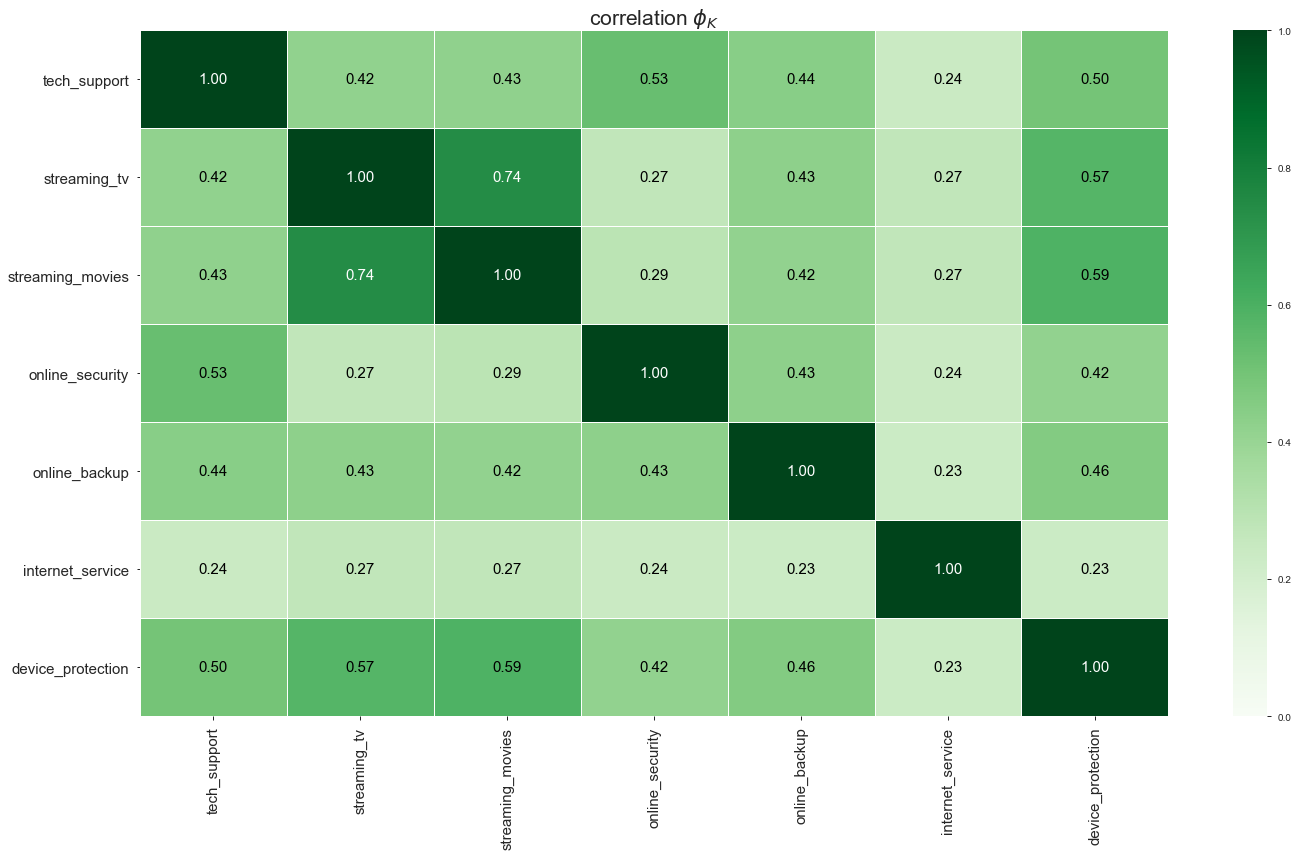

In [199]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(20, 12))
plt.tight_layout()

Видим некоторую зависимость между 'streaming_tv' и 'streaming_movies'. А в остальном все в пределах нормы.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p> таааааак, с phik понятно.)

 6. На целевой признак влияет 'internet_service'.

In [200]:
df_cat[(df_cat['churn']==1)].groupby(['internet_service', 'multiple_lines'])['gender'].count()

internet_service  multiple_lines
DSL               No                216
                  Unknown           170
                  Yes                73
Fiber optic       No                530
                  Yes               767
No                No                103
                  Yes                10
Name: gender, dtype: int64

Видим, что больше всего ушло людей, пользующихся и Fiber optic и телефонией - подавляющее большинство. 

Возможно, способ подключения по оптическому каналу появился недавно?

In [201]:
df_cat[df_cat['internet_service']=='Fiber optic']['begin_date'].sort_values()

customerID
2889-FPWRM   2013-10-01
0917-EZOLA   2013-10-01
7317-GGVPB   2013-11-01
2834-JRTUA   2013-11-01
1555-DJEQW   2013-12-01
                ...    
2424-WVHPL   2020-01-01
1640-PLFMP   2020-01-01
2468-SJFLM   2020-01-01
7439-DKZTW   2020-01-01
1452-VOQCH   2020-01-01
Name: begin_date, Length: 3096, dtype: datetime64[ns]

Нет. был давно. Возможно, тарифы изменились?

Посмотрим на клиентов с высоким ежемесячным платежом в группировке по факту ухода.

In [202]:
df_cat[df_cat['monthly_charges']>100].groupby('churn').count()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fact_month,m_month
churn,,,,,,,,,,,,,,,,,,,,,
0,649,649,649,649,649,649,649,649,649,649,...,649,649,649,649,649,649,649,649,649,649
1,253,253,253,253,253,253,253,253,253,253,...,253,253,253,253,253,253,253,253,253,253


Видим, что с платежом больше 100 у.е. уходит только 25% клиентов. 

Посмотрим медианный платеж у клиентов, подключившихся до 1 января 2017 года.

In [203]:
df_cat[(df_cat['begin_date'] < '2017-01-01')][['monthly_charges', 'churn']].mean()

monthly_charges    72.308274
churn               0.126053
dtype: float64

Видим, что клиенты почти не уходят. 

Посмотрим медианный платеж у клиентов, подключившихся после 1 января 2017 года.

In [204]:
df_cat[(df_cat['begin_date'] > '2017-01-01')][['monthly_charges', 'churn']].mean()

monthly_charges    59.211597
churn               0.370157
dtype: float64

Видим, что средний платеж стал меньше, но клиенты стали больше уходить!

Посмотрим на те же данные, но при условии подключения по оптическому каналу. 

In [205]:
df_cat[(df_cat['begin_date'] < '2017-01-01')&(df_cat['internet_service']=='Fiber optic')][['monthly_charges', 'churn']].mean()

monthly_charges    99.346191
churn               0.220314
dtype: float64

In [206]:
df_cat[(df_cat['begin_date'] > '2017-01-01')&(df_cat['internet_service']=='Fiber optic')][['monthly_charges', 'churn']].mean()

monthly_charges    85.420747
churn               0.572917
dtype: float64

Видим, что до 2017 года средний платеж был вообще 100 у.е., но клиентов уходит немного. А в последние года средний платеж уменьшился, а уходить стало больше половины клиентов. 

Возможно стоит подумать о качестве оказываемых услуг?

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>ОК, вот это, что называется "зри в корень")) У нас же ещё с более выгодным конкурентным предложением может быть связан большой отток. Или была акция, которая привлекла много-много клиентов. А потом они разочаровались или что-то выгодное закончилось и все ушли... много версий..</p>
</div>

Посмотрим описательные статистики и ящики с усами. Может быть у нас есть выбросы?

Смотреть будем на оригинальном датафрейме - df.

In [207]:
df[df['churn']==1].describe()

,senior_citizen,monthly_charges,total_charges,churn,days
count,1869.000000,1869.000000,1869.000000,1869.0,1869.000000
mean,0.254682,74.441332,1531.796094,1.0,547.352060
std,0.435799,24.666053,1890.822994,0.0,594.389607
min,0.000000,18.850000,18.850000,1.0,30.000000
25%,0.000000,56.150000,134.500000,1.0,61.000000
50%,0.000000,79.650000,703.550000,1.0,304.000000
75%,1.000000,94.200000,2331.300000,1.0,883.000000
max,1.000000,118.350000,8684.800000,1.0,2191.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1fa99f9ba60>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa99fa8040>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa99f9b790>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa99fa85e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa99fa88b0>],
 'means': []}

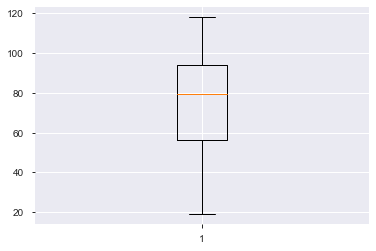

In [208]:
plt.boxplot(df[df['churn']==1]['monthly_charges'])

In [209]:
df[df['churn']==0].describe()

,senior_citizen,monthly_charges,total_charges,churn,days
count,5163.000000,5163.000000,5163.000000,5163.0,5163.000000
mean,0.128995,61.307408,2555.344141,0.0,1146.885532
std,0.335227,31.094557,2329.456984,0.0,732.773458
min,0.000000,18.250000,18.800000,0.0,31.000000
25%,0.000000,25.100000,577.825000,0.0,457.000000
50%,0.000000,64.450000,1683.600000,0.0,1157.000000
75%,0.000000,88.475000,4264.125000,0.0,1857.000000
max,1.000000,118.750000,8672.450000,0.0,2191.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1fa99ff9fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa9a009580>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa99ff9cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa9a009b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa9a009df0>],
 'means': []}

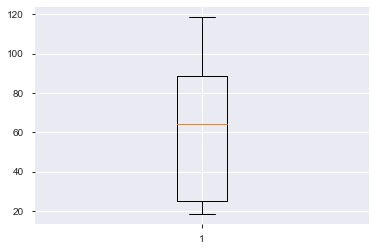

In [210]:
plt.boxplot(df[df['churn']==0]['monthly_charges'])

<div class="alert alert-block alert-info">
<b>Дорогой ревьюер, вопрос:</b> Как мне нарисовать оба ящика с усами на одном графике?
</div>

 <div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
Можно по разному. <br>
А можно расположив два рядом с использование конструкции subplots:<br>
fig, ax = plt.subplots(1,2, figsize=(...))<br>
.....

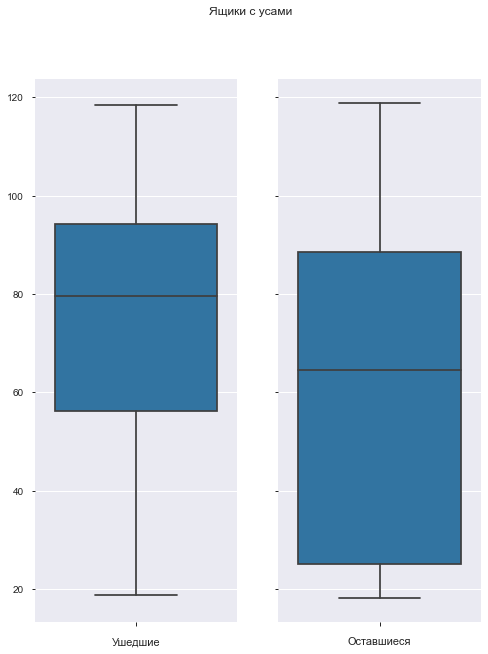

In [211]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
sns.boxplot(data=df[df['churn']==1], y='monthly_charges', ax=ax1)
sns.boxplot(data=df[df['churn']==0], y='monthly_charges', ax=ax2)

ax1.set_xlabel('Ушедшие'), ax1.set_ylabel('')
ax2.set_xlabel('Оставшиеся'), ax2.set_ylabel('')
plt.suptitle(
    'Ящики с усами')
plt.show()

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
    <p><u><b>КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
КРУТО! СПАСИБО!

Выбросов не обнаружено. Но можно видеть, что среднее значение платежа у ушедших больше. Также можно отметить, что у оставшихся разброс значений платежа большой, в то время, как у ушедщих значения ежемесячного платежа более компактны. 

Построим гистограммы платежей у ушедших и оставшихся клиентов. Для этого напишем отдельную функцию.  

In [212]:
def phist(i, st, text_pay, text_client):
    df[df['churn']==i][st].hist()
    plt.xlabel( text_pay)
    plt.ylabel('Количество клиентов')
    plt.title(f'Платежи {text_client} клиентов')
    plt.show() 

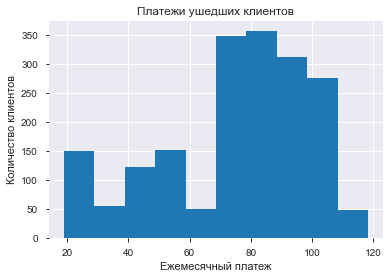

In [213]:
phist(1, 'monthly_charges', 'Ежемесячный платеж',  'ушедших')

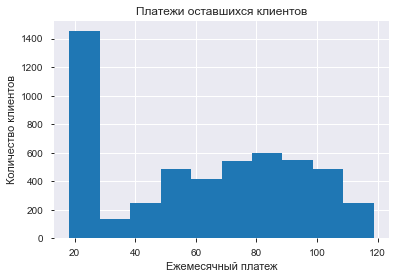

In [214]:
phist(0, 'monthly_charges', 'Ежемесячный платеж',  'оставшихся')

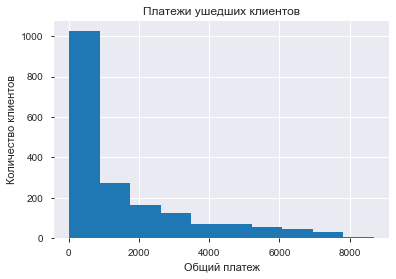

In [215]:
phist(1, 'total_charges', 'Общий платеж',  'ушедших')

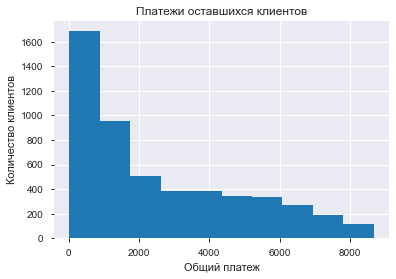

In [216]:
phist(0, 'total_charges', 'Общий платеж',  'оставшихся')

В целом, гистограммы подтвердили наши выводы из ящиков с усами. 

Таким образом, не вижу поводов для корректировки df. А df_cat мы использовали для удобства. 

На мой взгляд, конкретные даты начала и конца конктрата не так уж важны. А дату конца точно надо убирать, тк это "слив" информации. Эти стобцы удаляем. Также удалим 'total_charges', так как он коррелирует с ежемесячным платежем. 

In [217]:
df = df.drop(columns = ['end_date','begin_date','total_charges'], axis = 1)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
ОТЛИЧНО, что удаляешь факторы-даты!!!!! Если у нас тема НЕ временные ряды, то такие факторы лучше не использовать. Они "нагонят" метрики, но бизнес-эффективность модели  - рухнет.

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7032 non-null   object 
 1   senior_citizen     7032 non-null   int64  
 2   partner            7032 non-null   object 
 3   dependents         7032 non-null   object 
 4   type               7032 non-null   object 
 5   paperless_billing  7032 non-null   object 
 6   payment_method     7032 non-null   object 
 7   monthly_charges    7032 non-null   float64
 8   churn              7032 non-null   int64  
 9   days               7032 non-null   int64  
 10  internet_service   7032 non-null   object 
 11  online_security    7032 non-null   object 
 12  online_backup      7032 non-null   object 
 13  device_protection  7032 non-null   object 
 14  tech_support       7032 non-null   object 
 15  streaming_tv       7032 non-null   object 
 16  streaming_movi

##### Удаление дубликатов

In [219]:
df = df.drop_duplicates().reset_index(drop = True)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7009 non-null   object 
 1   senior_citizen     7009 non-null   int64  
 2   partner            7009 non-null   object 
 3   dependents         7009 non-null   object 
 4   type               7009 non-null   object 
 5   paperless_billing  7009 non-null   object 
 6   payment_method     7009 non-null   object 
 7   monthly_charges    7009 non-null   float64
 8   churn              7009 non-null   int64  
 9   days               7009 non-null   int64  
 10  internet_service   7009 non-null   object 
 11  online_security    7009 non-null   object 
 12  online_backup      7009 non-null   object 
 13  device_protection  7009 non-null   object 
 14  tech_support       7009 non-null   object 
 15  streaming_tv       7009 non-null   object 
 16  streaming_movies   7009 

### Вывод

Таким образом, исходя из выше проведенного исследовательского анализа данных, для клиента, который уйдет характерны следующие признаки: 

0. Он пришел к пройвайдеру в последние несколько лет.
1. Он пользуется интернетом. 
2. Интернетом он пользуется по оптоволокну.
3. По мимо интернета он также пользуется телефонией с возможностью многоканальных звонков. 
4. Он скорее пенсионер. =)

Благодаря проведенному анализу, мы попытались нарисовать портрет типичного клиента, который уйдет. 

Что касается подготовки данных к последующему обучению моделей, то, согласно плану:
1. столбцы были приведены к змеиному регистру,
2. данные были очищены от пропусков,
3. выбросов в количественных признаках найдено не было,
4. был добавлен столбец days (срок жизни клиента в днях), 
5. было произведено изменение типов данных, в частности дат,
6. просмотр распределения данных был произведен на количественных признаках,
7. столбцы с датами были удалены, так как из-за них происходит утечка данных,
8. дубликаты удалены,
9. в итоге была получена склеиная их четырех исходных таблица, готовая к использованию в дальнейшем машинном обучении,
10. в конце были удалены дубликаты.


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
Чёткая и внимательная работа по разделу. ОК.

## Предобработка данных перед обучением

### Кодирование категориальных признаков

In [105]:
df.head(3)

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,Unknown
1,Male,0,No,No,One year,No,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,No


Так как планируем использовать разные модели для обучения, в том числе и линейные, такие как логистическая регресиия, то нельзя использовать технику OrdinalEncoder. Будеи использовать OHE, убирая первый признак. 

In [106]:
df = pd.get_dummies(df,drop_first=True)
print(df.head())
df.info()

   senior_citizen  monthly_charges  churn  days  gender_Male  partner_Yes  \
0               0            29.85      0    31            0            1   
1               0            56.95      0  1036            1            0   
2               0            53.85      1    61            1            0   
3               0            42.30      0  1371            1            0   
4               0            70.70      1    61            0            0   

   dependents_Yes  type_One year  type_Two year  paperless_billing_Yes  ...  \
0               0              0              0                      1  ...   
1               0              1              0                      0  ...   
2               0              0              0                      1  ...   
3               0              1              0                      0  ...   
4               0              0              0                      1  ...   

   internet_service_Fiber optic  internet_service_No  online_s

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
С этим понятно, ОК.

### Проверка признаков на взаимную корреляцию

In [107]:
features = df.drop(['churn'], axis=1)
target = df['churn']

Проверим, есть ли корреляция между признаками. Будем смотреть на коэффициент Phik.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>👍</p>
</div>

In [108]:
df.head(2)

,senior_citizen,monthly_charges,churn,days,gender_Male,partner_Yes,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,...,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Unknown,multiple_lines_Yes
0,0,29.85,0,31,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,56.95,0,1036,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [109]:
interval_cols = ['monthly_charges','days']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

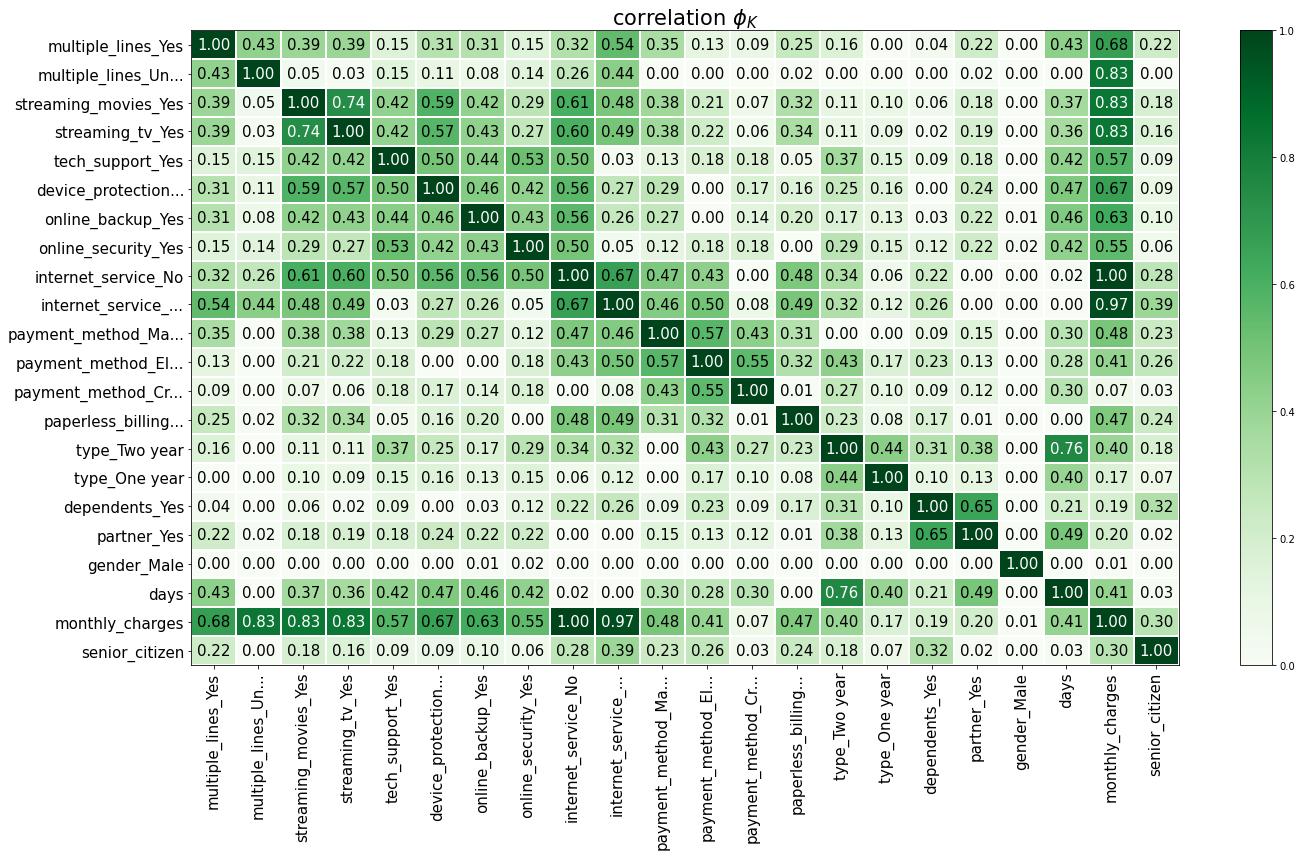

In [110]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(20, 12))
plt.tight_layout()

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Если я верно сделала, то видим сильную корреляцию между 'monthly_charges' и следующими столбцами: 'internet_service_No','internet_service_Fiber optic', 'streaming_tv_Yes', 'streaming_movies_Yes' и 'multiple_lines_Unknown', а также между 'streaming_tv_Yes' и 'streaming_movies_Yes'. 
    
А как теперь проверить их достоверность, напомни, пожалуйста??
 и, если подтвердится, то потом все-таки делать - удалять один из стобцов?

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>Я бы про удаление говорил только тогда, когда речь идёт о количественных данных. Именно в этом случае принято говорить о мкльтиколлинераности и последующем уделении одного из признаков (но это не обязательное правило - всё на усмотрение аналитика).</p>
Достоверность корреляции смотретися через вывод p-уровня значимости расчёта. Тут надо просто в самой библлиотеке "покопаться" - есть ли у их такая возможность. Т.к сама библиотека отностительно новая.
</div>

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
        <p><u><b> КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
    <p>Я а попробуем не удалять и посмотрим, что будет.</p>
"Достоверность корреляции смотретися через вывод p-уровня значимости расчёта." Вот здесь совсем не поняла о чем речь! =(
</div>

/opt/conda/lib/python3.9/site-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


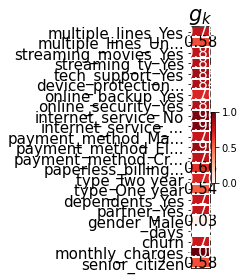

In [111]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4), # и ВОТ ЗДЕСЬ СТОЯЛА БУКВА "и" - УДАЛИЛ ЕЁ, СЧИТАЕТ.
                        color_map="Reds", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Данная ячейка, ругается, посмотри, пожалуйста, в чем дело. 

interval columns not set, guessing: ['senior_citizen', 'monthly_charges', 'churn', 'days', 'gender_Male', 'partner_Yes', 'dependents_Yes', 'type_One year', 'type_Two year', 'paperless_billing_Yes', 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'payment_method_Mailed check', 'internet_service_Fiber optic', 'internet_service_No', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Unknown', 'multiple_lines_Yes']


/opt/conda/lib/python3.9/site-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(
/opt/conda/lib/python3.9/site-packages/phik/report.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


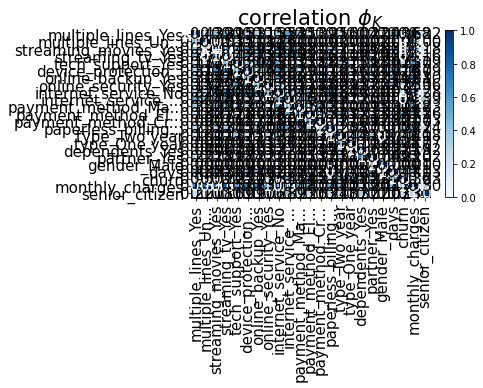

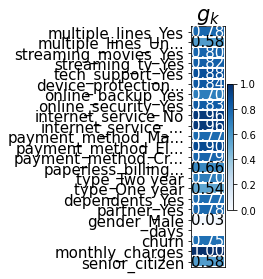

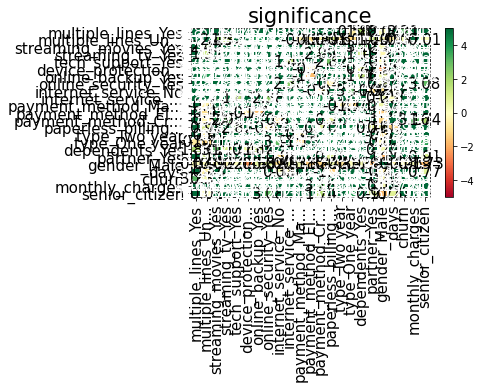

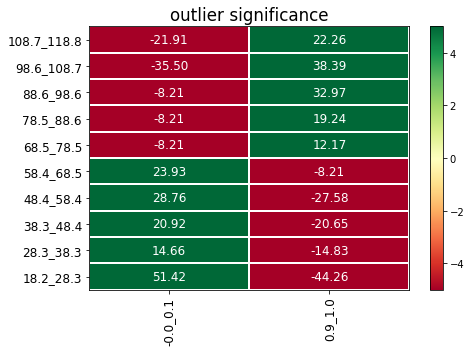

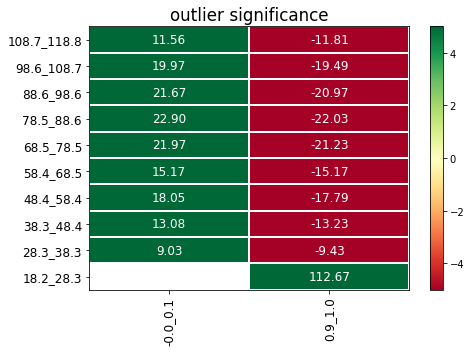

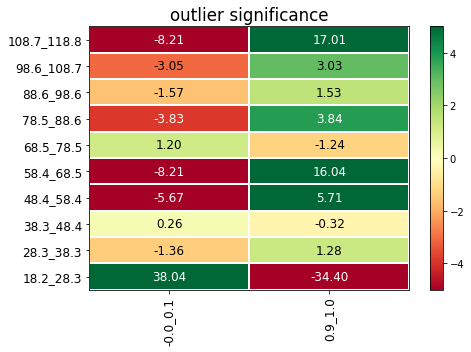

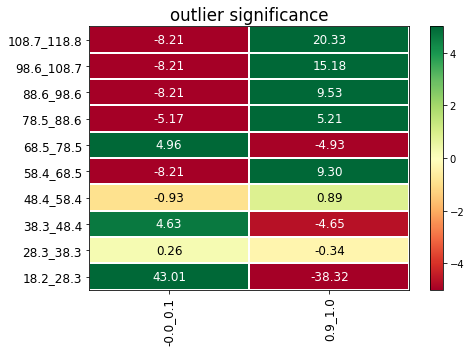

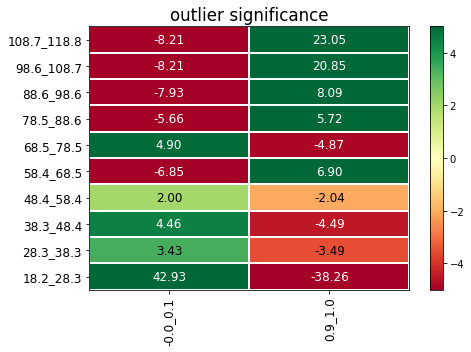

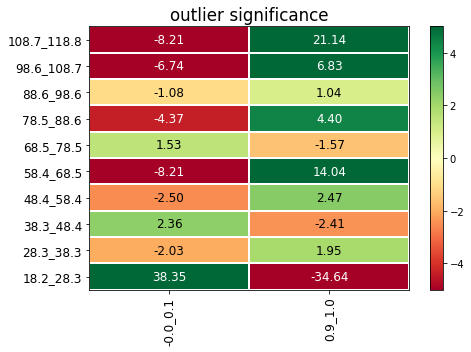

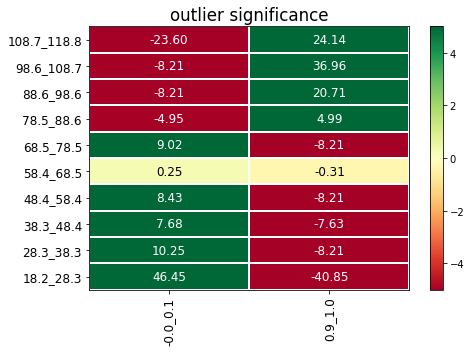

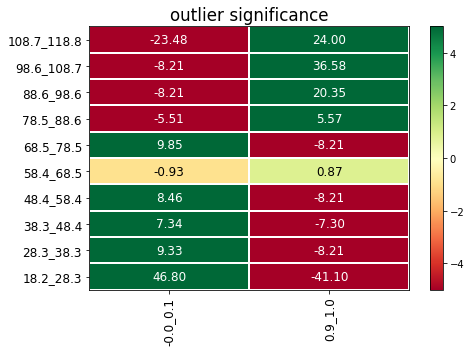

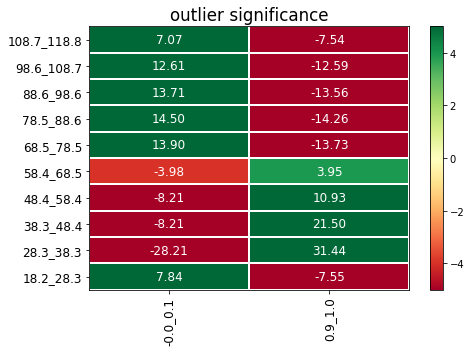

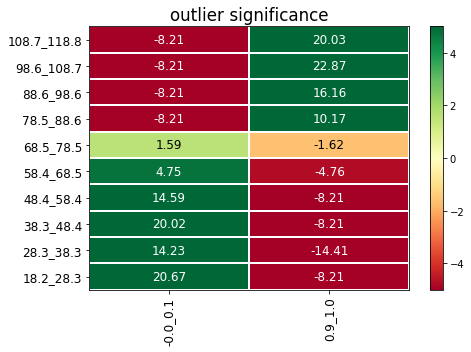

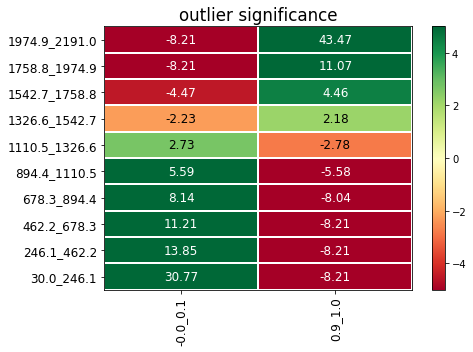

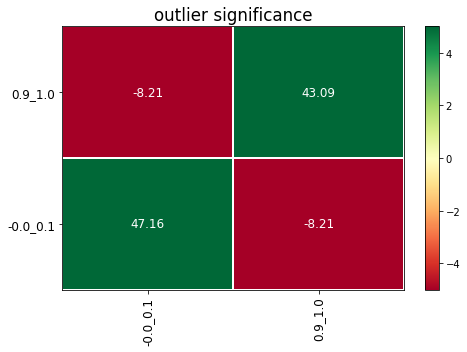

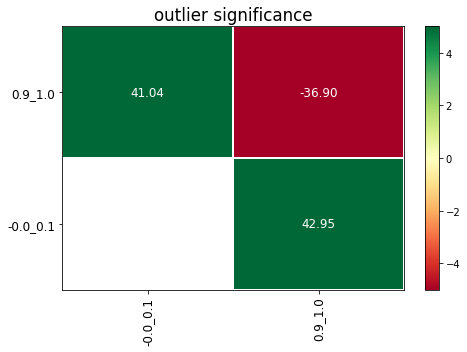

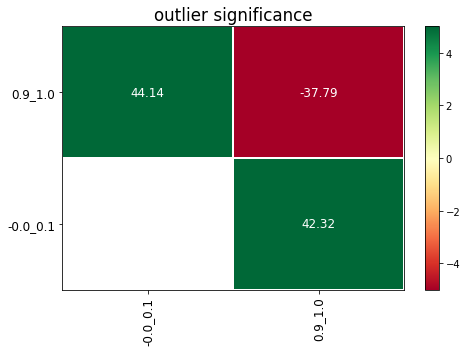

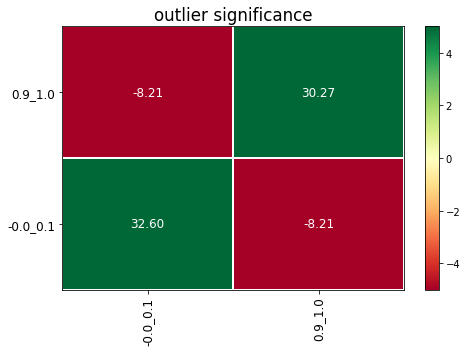

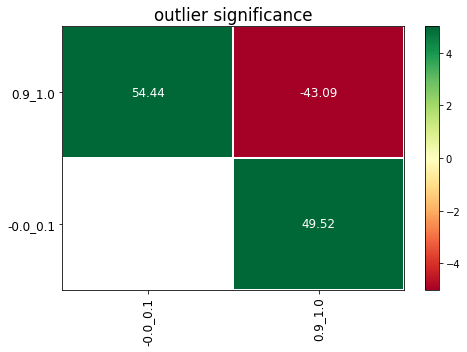

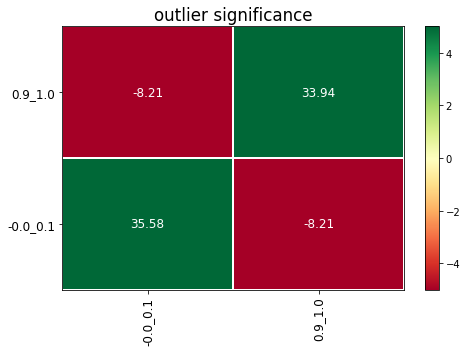

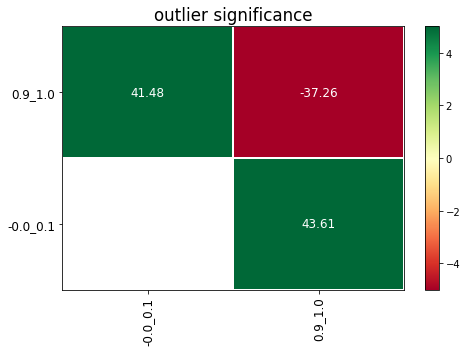

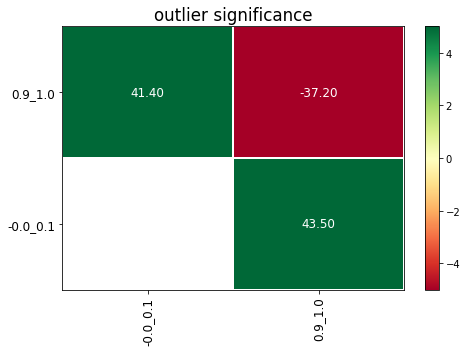

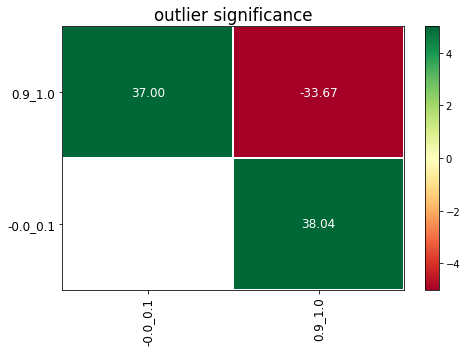

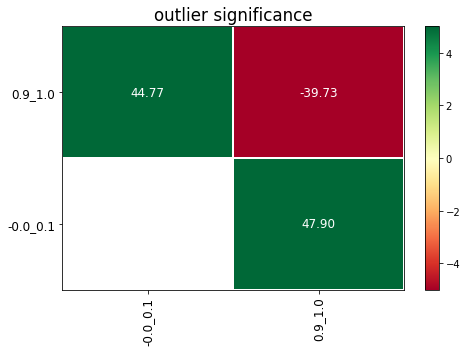

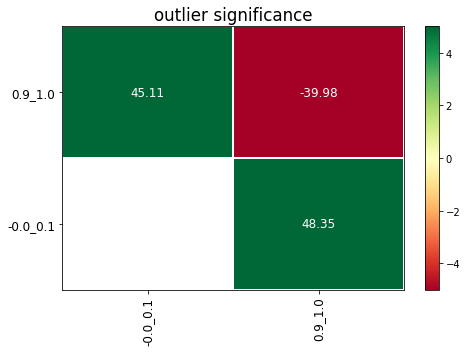

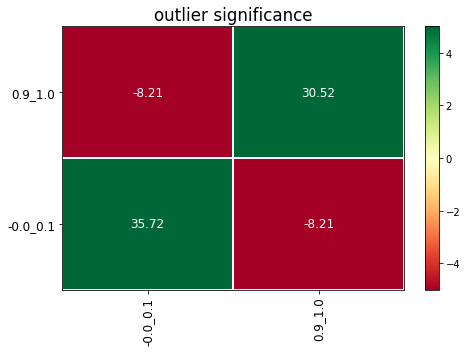

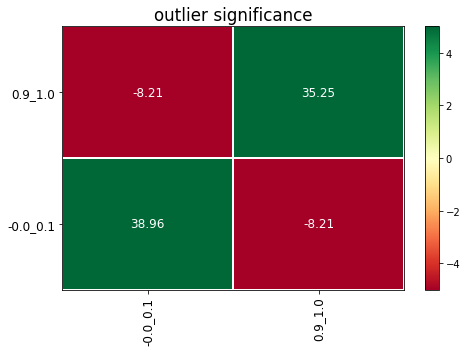

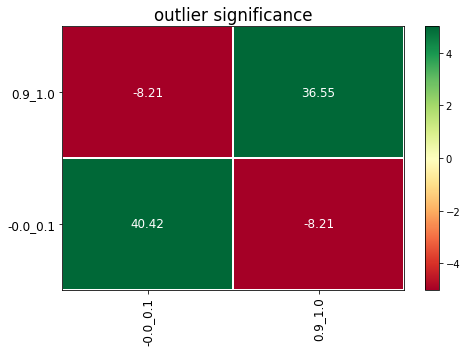

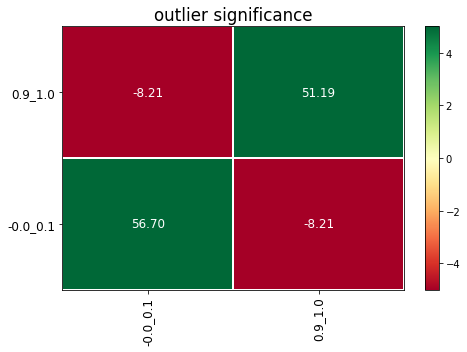

In [112]:
rep = report.correlation_report(df, significance_threshold=3, correlation_threshold=0.5)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Данная ячейка, ругается, посмотри, пожалуйста, в чем дело. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>всё сработало.... только тяженько читается))))</p>
</div>

Удалим столбцы с большой корреляцией. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>Как и писал выше, я бы не удалял категоризированные факторы, опираясь на корреляцию. Но тут нет единого мнения.</p>
</div>

In [113]:
interval_cols = ['monthly_charges','days']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

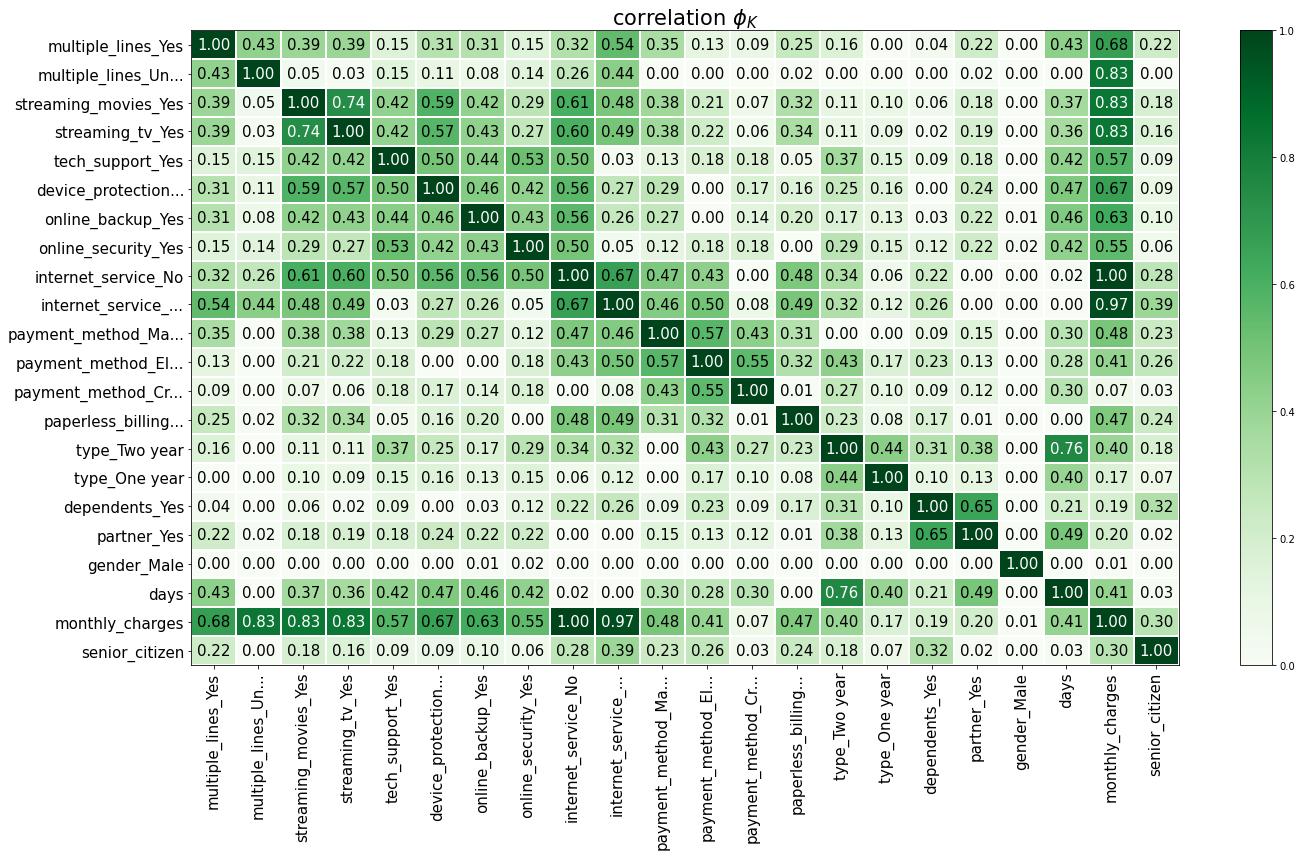

In [114]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

In [115]:
interval_cols = ['monthly_charges']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

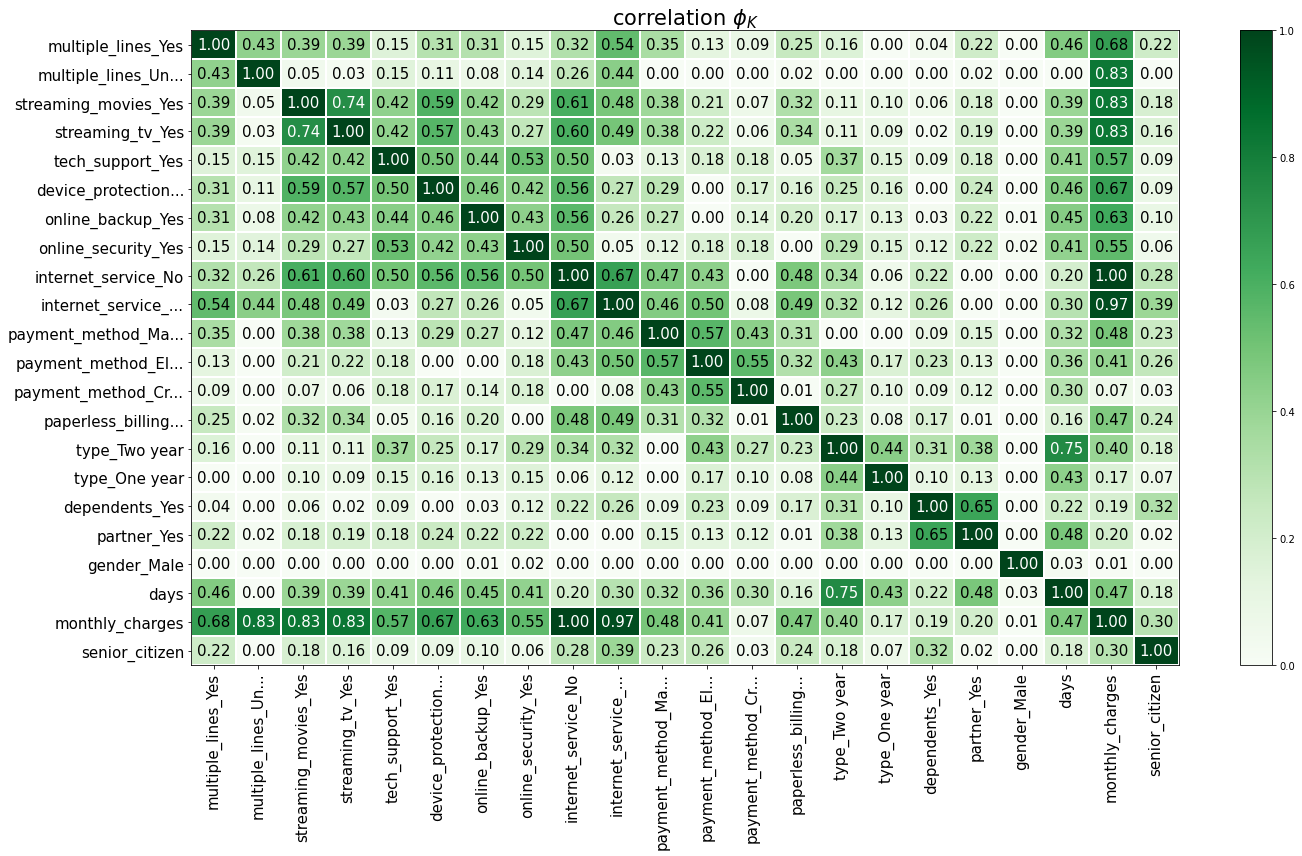

In [116]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

In [117]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   senior_citizen                          7009 non-null   int64  
 1   monthly_charges                         7009 non-null   float64
 2   days                                    7009 non-null   int64  
 3   gender_Male                             7009 non-null   uint8  
 4   partner_Yes                             7009 non-null   uint8  
 5   dependents_Yes                          7009 non-null   uint8  
 6   type_One year                           7009 non-null   uint8  
 7   type_Two year                           7009 non-null   uint8  
 8   paperless_billing_Yes                   7009 non-null   uint8  
 9   payment_method_Credit card (automatic)  7009 non-null   uint8  
 10  payment_method_Electronic check         7009 non-null   uint

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>Уххх, плотная работа с корреляциями, но интересная. Своё мнение по категориальным - озвучил выше)</p>
</div>

### Разделение на обучающую и тестовую выборки

Разделим выборку на обучающую и тестовую для использования в общей функции в отношении 4:1 (def algorithm_pipeline_3)

In [118]:
features_train, features_test, target_train, target_test = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

Проверим корректность разделения исходных данных на выборки.

In [119]:
features_train.shape, features_test.shape, 

((5607, 22), (1402, 22))

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>тааааак, две выборки и есть проверка их размерности.</p>
</div>

Разделение выполнено корректно. 
Проверим баланс классов.

In [120]:
target_train.mean(), target_test.mean()

(0.2655609060103442, 0.2653352353780314)

Баланс классов равный благодаря параметру stratify. Чего и следовало ожидать. 

### Масштабирование признаков

Произведем масштабирование признаков. Мной были испробованы три варинта: StandardScaler, MinMaxScaler и RobustScaler. Однако по моей субъективной оценке, полученной исключительно эмпирическим путем, наилучший результат все-таки дает старый добрый  StandardScaler. 

<div class="alert alert-block alert-info">
<b> Дорогой ревьюер, вопрос:</b> Прокомментируй, пожалуйста, что-нибудь об использовании того или иного инструмента применительно к нашей задаче. 
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
    <p>масштабирование раздеьное по выборка - ОК. Но у нас количественные шкалы только вот эти "monthly_charges  days " Остальные можно причислить к категориальным. А само масштабирование разработывалось именно к количественным шкалам. Категориальные можно не подвергать этой процедуре.<br>
Какой лучше:<br>
Вот здесь есть начало рассуждений по этой теме: https://translated.turbopages.org/proxy_u/en-ru.ru.c4ef68f9-62eba2f4-db19e97f-74722d776562/https/www.baeldung.com/cs/normalization-vs-standardization<br>
        
У нас только 2 фактора надо стандартизировать. Я бы здесь использовал классический подход стандартизации. По другим видам - видел где-то статью, где сравнивают все подходы (их быо около 10 в статье) между собой (жалко не скопировал её себе... но можно поискать самой..). Там идея была что нет одного универсального способа на все случаи жизни. У кадого своя особенность, исходя из особенностей самих данных. А если есть соменение. какой применять, то делаем классику - через сигму (стандартизация) или пробуем 2-3 варианта и сравниваем результат.
</p>
</div>

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
        <p><u><b> КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
    <p>Давай масштабируем только количественные, ок. и посмотрим, как оно там будет. А что значит через сигму 
        ("через сигму (стандартизация)" )
</div> 

In [121]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head(10)) 

      senior_citizen  monthly_charges      days  gender_Male  partner_Yes  \
2613               0         0.466521  1.564370            1            1   
5846               0        -0.312023 -0.355689            1            0   
2029               1         0.184319 -1.292270            0            0   
1462               0         0.288900 -0.393206            0            0   
1783               0         0.433321 -0.844748            0            0   
550                0         1.678326  1.601887            0            1   
4293               0        -0.479684 -0.434742            0            0   
3600               1        -0.497944  0.911845            1            0   
3789               0         0.964523  1.154365            1            1   
5526               0         1.090684 -1.210537            0            0   

      dependents_Yes  type_One year  type_Two year  paperless_billing_Yes  \
2613               0              0              1                      1  

/tmp/ipykernel_134/3159239522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_134/3159239522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### Вывод 

Данные готовы к дальнейшей работе с ними: 

1. категориальные признаки преобразованы в численные техникой OHE
2. определен целевой признак 'churn',
3. произведено разбиение на обучающую и тестовую выборки в отношении 4:1,
4. выполнено масштабирование признаков
5. построена матрица корреляции с использованием коэффициента Phik.

## Обучение моделей

### Поиск гиперпараметров модели с помощью RandomizedSearchCV

In [122]:
#зафиксируем значение генератора случайных чисел для воспроизводимости
seed = 250722

Создадим общую функцию для подбора гиперпараметров моделей. Функция получает на вход параметры, модель, оценщиков (в нашем случае будем смотреть сразу три оценки: 'accuracy', 'f1', 'roc_auc'. Но главная метрика для нас - ROC-AUC. 
Функция выводит обученную модель, оценку на обучающей выборке и наилучшиме параметры модели. 

<div class="alert alert-block alert-info">
<b>Дорогой ревьюер, вопрос:</b> вот при подсчете сразу трех метрик: score=['accuracy', 'f1', 'roc_auc'] модель понимает, что для ROC-AUC надо считать предсказание вероятности predict_proba, а не категориальное предсказание. Судя по тому, что до этого у меня была другая функция, которая отдельно ROC - AUC считала,то кажется, что алгоритм нормально работает. Но это не точно. 
Кстати, я верно написала функцию algorithm_pipeline_3 в ячейке выше?  в плане расссета сразу трех метрик?
</div> 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
А может другую конструкцию использовать? оптимизируем все модели по АУК. А для каждой потом просто считаем метрики и выводим. Напрмер так, как ниже. И тогда многие вопросы, что ниже ты задавала уйдут)

Создадим такблицу для записи получившихся метрик. 

In [127]:
# функция подсчета времени
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    time_in_sec = h * 60 * 60 + m *60 + s
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
    return time_in_sec

In [128]:
def model_test(mdl, param, name_mld):
    
    ''' 
    Функция обучение модели:
    param mdl: получает алгоритм обучения модели;
    param param: параметры для обучения;
    param name_mld: название алгоритма обучения;
    return: отсутствует, данные вносятся в df.
    '''
        
    model = mdl
    rand_research_cv = RandomizedSearchCV(estimator = model, param_distributions = param, cv=5, scoring = 'roc_auc' )
    
    # обучение модели
    start = time.time()
    rand_research_cv.fit(features_train,target_train)
    end = time.time()
    time_work = exec_time(start,end)
    
    # сохраняем лучшую модель в переменную
    best = rand_research_cv.best_estimator_
    
    # проверим работу модели на тестовых данных
    predicted_test = best.predict(features_test)
    probabilities_test = best.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    
    # расчитаем метрики
    r_auc = roc_auc_score(target_test, probabilities_one_test)
    acc = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    precision = precision_score(target_test, predicted_test, pos_label= 1)
    recall = recall_score(target_test, predicted_test, pos_label=1)
    
    # добавим данные в датафрейм для дальнейшего сравнения
    #df_scor_train.append(name_mld, r_auc, acc, f1, precision, recall, time_work)
    data = {'name': [name_mld], 
            'params' : [best],
            'roc_auc': [r_auc],
            'accuracy': [acc],
            'f1': [f1],
            'precision' : [precision],
            'recall' : [recall],
            'time': [time_work]
           }
    #print(pd.DataFrame(data))
    
    #df_scor_train.append(pd.DataFrame(data), ignore_index=True)
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    print('\n ROC AUC:', round(r_auc,3))
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show() 
    
    return (pd.DataFrame(data))

In [129]:
df_scores = []
df_scores = pd.DataFrame(data=None,
                          index=None,
                          columns=['name', 'params', 'roc_auc', 'accuracy', 'f1', 'precision', 'recall', 'time'],
                          dtype=None,
                          copy=False)
df_scores

,name,params,roc_auc,accuracy,f1,precision,recall,time


<div class="alert alert-info" style="border-color: green; border-radius: 5px">
        <p><u><b> КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p>
    <p> Вопрос первый: КАК МОДЕЛЬ ПОНИМАЕТ, ЧТО МЫ ЕЙ ПОДАЕМ обучающую и тестовую выборки? мы же ей их не передаем??
        
второй: я подправила немного твою функцию, а то не работало, особенно на моменте добавления полученных оценок в таблицу. Сейчас не ругается, но кажется, все равно не добавляет ничего =(( 
UPD: прищлось append для каждой модели писать. А как по-другому??
        
третий: получается мы сразу и на тестовой выборке проверям? то есть потом уже лучшую модель проверять не нужно?
</div> 

#### RandomForestClassifier

Execution Time: 00:00:17

 ROC AUC: 0.867


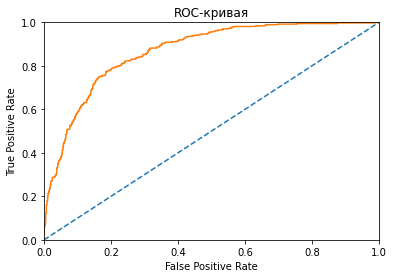

In [130]:
v = model_test(RandomForestClassifier(random_state=seed, class_weight='balanced'), 
           [{'n_estimators': range(10, 200, 5),
             'max_depth': range(10, 200, 5),
             'max_leaf_nodes': range(10, 200, 5),
             'min_samples_split' : [2,3,4],
             'criterion' : ['gini', 'entropy']}], 'RandomForestClassifier')

df_scores = df_scores.append(v, ignore_index=True)

<div class="alert alert-block alert-info">
<b>Дорогой ревьюер, вопрос:</b> Здесь и далее в GradientBoostingClassifier вылезает ошибка. По-моему, жэто связано с сохранением параметров лучшей модели в мою таблицу. Помоги, пожалуйста, разобраться. 
</div>

<div class="alert alert-block alert-info">
<b>Дорогой ревьюер, вопрос:</b> Здесь и далее мне пришлось вручную добавлять текущие оценки в таблицу оценок:
    
    ''' df_scor_train.iloc[0] = sc '''
    
    и вручную менять индексы для каждой модели. Как мнем это сделать автоматизированно, подскажи, пожалуйста! не справилась я.
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Вот выше предложил вараинт - просто изменить принцип работы функции.

<div class="alert alert-block alert-info">
<b>Дорогой ревьюер, и еще такой вопрос:</b> Для каждой метрики качества модель подбирает свои лучшие гиперпараметры. А как нам сделать так, чтоб она считала все три метрики, но на лучших параметрах только для ROC-AUC?. Я пыталась менять параметр refit, но как-то не помогло =(
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Вот в той функции как раз реализовано.

#### DecisionTreeClassifier

Execution Time: 00:00:01

 ROC AUC: 0.849


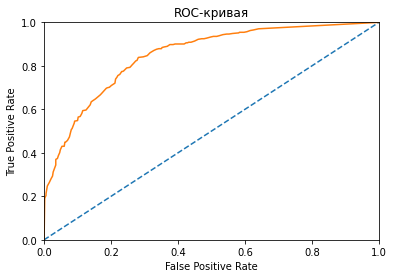

In [131]:
v = model_test(DecisionTreeClassifier(random_state=seed, class_weight='balanced'), 
           [{
    'max_depth': range(10, 200, 5),
    'min_samples_split' : [int(x) for x in np.linspace(start = 2, stop = 30, num = 15)],
    'min_samples_leaf' : [int(x) for x in np.linspace(start = 1, stop = 30, num = 15)]
           }], 
               'DecisionTreeClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### LogisticRegression

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Execution Time: 00:00:12

 ROC AUC: 0.849


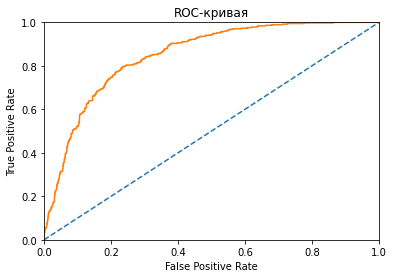

In [132]:
v = model_test(LogisticRegression(random_state=seed, class_weight='balanced'), 
           [{
    'penalty': ['l1', 'l2'],
    'C' : [0.1, 1.0, 5.0, 10.0],
    'intercept_scaling' : range(5, 100, 5),
    'solver' : ['liblinear', 'saga'],
    'max_iter' : range(5, 100, 5)
           }], 
               'LogisticRegression')

df_scores = df_scores.append(v, ignore_index=True)


#### LGBMClassifier

Execution Time: 00:00:26

 ROC AUC: 0.92


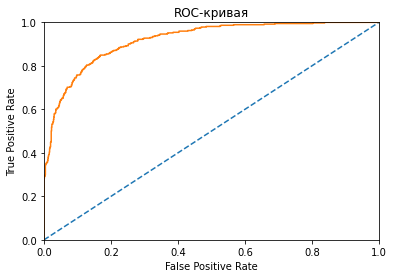

In [133]:
v = model_test(ltb.LGBMClassifier(random_state=seed, class_weight='balanced'), 
           [{
    'n_estimators': range (100, 200, 50),
    'colsample_bytree': [0.7, 0.8],
    'max_depth': range (10, 100, 20),
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
           }], 
               'LGBMClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### CatBoostClassifier

<div class="alert alert-block alert-info">
<b> Комментарий студента:</b> Здесь также работает, но по несколько часов, а метрика не самая высокая, поэтому в итоге решила закомментить.
    
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК, понял.

#### XGBClassifier

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
        <p><u><b> КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p> Я поняла, что в модели XGBClassifier для сбалансированности класоов надо передавать в параметр sample_weight массив с весами. Но как это сделать в моем случае? 
</div>

####  New

<div class="alert alert-block alert-info">
<b> Дорогой ревьюер, вопрос:</b> Данная модель accuracy посчитала, а при рассчете f1 начала ругаться: 
    
    FloatingPointError: underflow encountered in multiply
    
помоги, пожалуйста!
    
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p> Надо посмотреть в каком виде выводится результат у модели. Могут предсказ и фатк считаться вместе?  Например один - массив, доругой serias получается. Ребята пишут, что иногда такая ошибка возникает на уровне ядра ... Ещё он возможна при особенностях смих данных. Надо поэтапно смотреть код - результат строка за строкой, чтобы определить момент возникновения ошибки.

<div class="alert alert-block alert-info">
<b> Комментарий студента:</b> Здесь также работает, но по несколько часов, а метрика не самая высокая, поэтому в итоге решила закомментить.
    
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК.

#### Итоговая таблица 

In [135]:
df_scores = df_scores.sort_values(by = 'roc_auc', ascending = False)
df_scores

,name,params,roc_auc,accuracy,f1,precision,recall,time
3,LGBMClassifier,"LGBMClassifier(class_weight='balanced', colsam...",0.919509,0.844508,0.737349,0.668122,0.822581,26
4,XGBClassifier,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.911590,0.865193,0.724891,0.790476,0.669355,2278
0,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",0.867084,0.785307,0.663687,0.567878,0.798387,17
1,DecisionTreeClassifier,DecisionTreeClassifier(class_weight='balanced'...,0.849115,0.763195,0.639130,0.536496,0.790323,1
2,LogisticRegression,"LogisticRegression(class_weight='balanced', in...",0.848704,0.748217,0.630366,0.516295,0.809140,12


In [136]:
#estimators

Видим, что на данный момент наилучшая модель LogisticRegression не дает требуемый результат =(

#### Вывод 

В данном разделе для обучения были использоваы следующие ML модели: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, XGBClassifier. 

Поиск лучших гиперпараметров моделей осуществлялся с помощью RandomizedSearchCV.

Наилучшая модель дала неплохую метрику ROC-AUC. Пришло время проверить модель на тестовой выборке. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Давай!!!

## Тестирование моделей

Напишем функцию для расчета наших метрик и построения графика ROC кривой. 

In [137]:
#функция для AUC-ROC и графика
def auc_roc(model, features_test, target_test):
    
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    predicted_test = model.predict(features_test)
     
    auc_roc_model = roc_auc_score(target_test, probabilities_one_test)
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    
    print(f'AUC-ROC лучшей модели на тестовой выборке {auc_roc_model}') 
    print(f'Accuracy лучшей модели на тестовой выборке {accuracy}') 
    print(f'F1 лучшей модели на тестовой выборке: {f1}')
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    %matplotlib inline
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.show() 

AUC-ROC лучшей модели на тестовой выборке 0.9195088213801024
Accuracy лучшей модели на тестовой выборке 0.8445078459343794
F1 лучшей модели на тестовой выборке: 0.7373493975903614


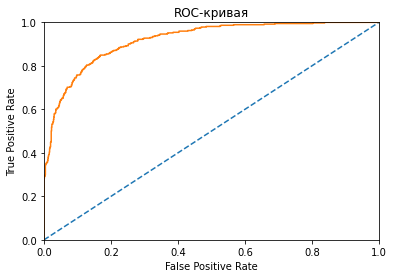

In [138]:
model = df_scores.iloc[0]['params']

auc_roc(model, features_test, target_test)

<div class="alert alert-block alert-info">
<b> Дорогой ревьюер, вопрос:</b> На тестовой выборке метрики стали лучше,чем на трейне. Насколько это в порядке вещей? Или все-таки дело в том, что при расчете трех метрик одновременно, модель не считает вероятность предсказания автоматически? то есть при обучении у нас не совсем корректные значения получаются?
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Тут скорее всего дело в predict_proba(). При её использовании аук чуть иной и выходит.

###  Важность признаков

In [139]:
def importance(model):
    importances = model.feature_importances_
    feature_list = list(features_train.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(16,10))
    feature_results.plot(kind='bar', x='feature', y='importance', ax=ax)
    ax.set_title(f'Важность признаков модели ')
    ax.set_ylabel('Важность')
    fig.tight_layout()

    print(feature_results.head(10))

                           feature  importance
0                             days        1793
1                  monthly_charges        1445
2            paperless_billing_Yes          46
3                 tech_support_Yes          35
4               multiple_lines_Yes          34
5                    type_One year          33
6  payment_method_Electronic check          32
7              online_security_Yes          28
8     internet_service_Fiber optic          27
9                    type_Two year          27


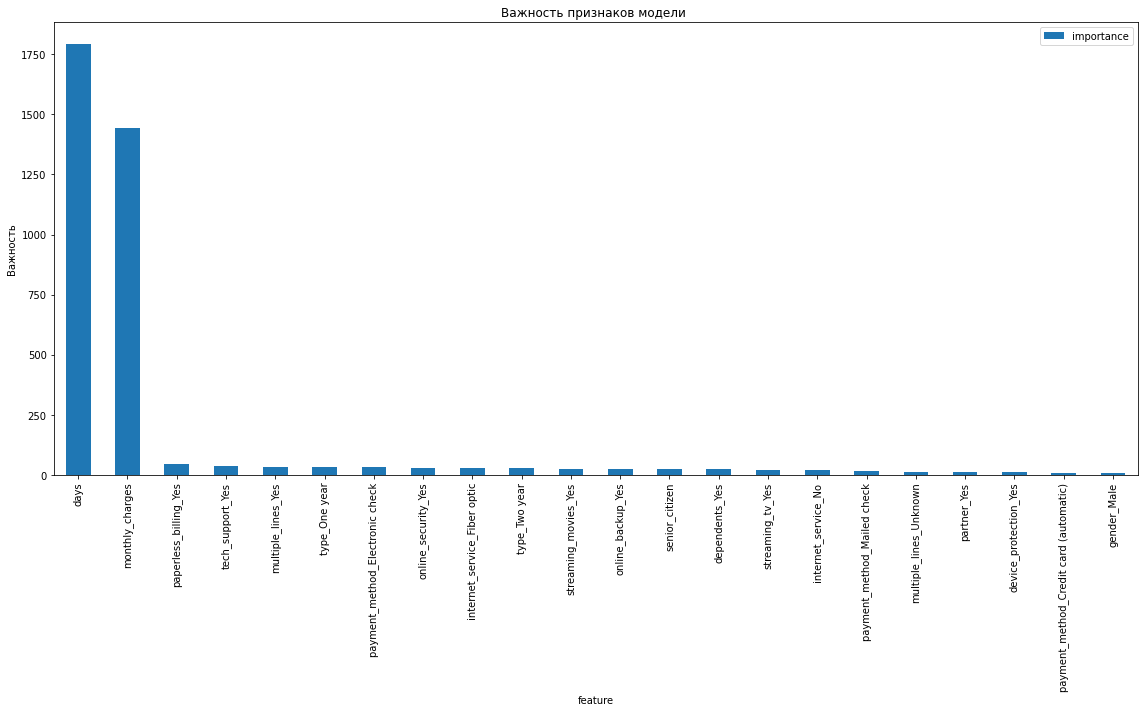

In [140]:
importance(model)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>хорошо, что используешь этот инструмент (слабочитаемый только...)). На начальном этапе мы можем нагенерить множество разных фич, в том чтисле и лишних. И вот этот инструмент, вкупе с анализом мультиколлинеарности позволяет избавляться от "балласта")

<div class="alert alert-block alert-info">
<b> Дорогой ревьюер, вопрос:</b> Мы получили важность признаков, и, как и следовало ожидать, days имеет наибольшее значение. Теперь в идеале мне надо удалить этот признак и попроовать заново? или что делать со знанием того, что какие-то признаки имеют большой вес?
    Чего мы хотим добиться с помощью таблицы важности: просто информация для себя или нам надо, чтоб все признаки имели примерно равный вес?
</div>

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
Нет, это не анализ ради анализа. Это важнее)) Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента. Т.е. Рейтинг выставляем. На практике это так: если хотим воздействовать на целевую, то с чего начинать? с воздействия на то, что сильнее влияет на целевую<br>

### Удаление маловажных фичей

In [142]:
features = features[['monthly_charges', 'days', 'paperless_billing_Yes', 'tech_support_Yes',
                     'multiple_lines_Yes', 'type_One year']]
target = df['churn']

In [143]:
features

,monthly_charges,days,paperless_billing_Yes,tech_support_Yes,multiple_lines_Yes,type_One year
0,29.85,31,1,0,0,0
1,56.95,1036,0,0,0,1
2,53.85,61,1,0,0,0
3,42.30,1371,0,1,0,1
4,70.70,61,1,0,0,0
...,...,...,...,...,...,...
7004,84.80,730,1,1,1,1
7005,103.20,2191,1,0,1,1
7006,29.60,337,1,0,0,0
7007,74.40,123,1,0,1,0


In [144]:
features_train, features_test, target_train, target_test = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

In [145]:
features_train.shape, features_test.shape, 

((5607, 6), (1402, 6))

In [146]:
target_train.mean(), target_test.mean()

(0.2655609060103442, 0.2653352353780314)

In [147]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head(10)) 

      monthly_charges      days  paperless_billing_Yes  tech_support_Yes  \
2613         0.466521  1.564370                      1                 1   
5846        -0.312023 -0.355689                      1                 0   
2029         0.184319 -1.292270                      1                 0   
1462         0.288900 -0.393206                      1                 1   
1783         0.433321 -0.844748                      0                 0   
550          1.678326  1.601887                      1                 1   
4293        -0.479684 -0.434742                      1                 0   
3600        -0.497944  0.911845                      1                 0   
3789         0.964523  1.154365                      1                 1   
5526         1.090684 -1.210537                      1                 1   

      multiple_lines_Yes  type_One year  
2613                   0              0  
5846                   1              0  
2029                   0             

/tmp/ipykernel_134/3159239522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_134/3159239522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [149]:
#функция для AUC-ROC и графика
def auc_roc_new(model, features_train, target_train, features_test, target_test):
    
    model.fit(features_train, target_train)
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    predicted_test = model.predict(features_test)
     
    auc_roc_model = roc_auc_score(target_test, probabilities_one_test)
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    
    print(f'AUC-ROC лучшей модели на тестовой выборке {auc_roc_model}') 
    print(f'Accuracy лучшей модели на тестовой выборке {accuracy}') 
    print(f'F1 лучшей модели на тестовой выборке: {f1}')
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    %matplotlib inline
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.show() 

AUC-ROC лучшей модели на тестовой выборке 0.9239129867418311
Accuracy лучшей модели на тестовой выборке 0.8487874465049928
F1 лучшей модели на тестовой выборке: 0.744578313253012


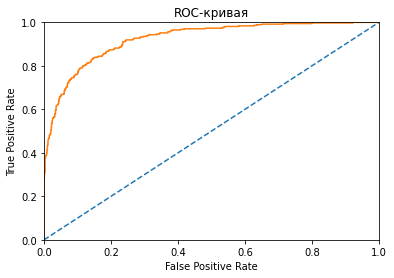

In [150]:
auc_roc_new(model, features_train, target_train,  features_test, target_test)

                 feature  importance
0                   days        2043
1        monthly_charges        1204
2          type_One year          44
3     multiple_lines_Yes          37
4  paperless_billing_Yes          35
5       tech_support_Yes          24


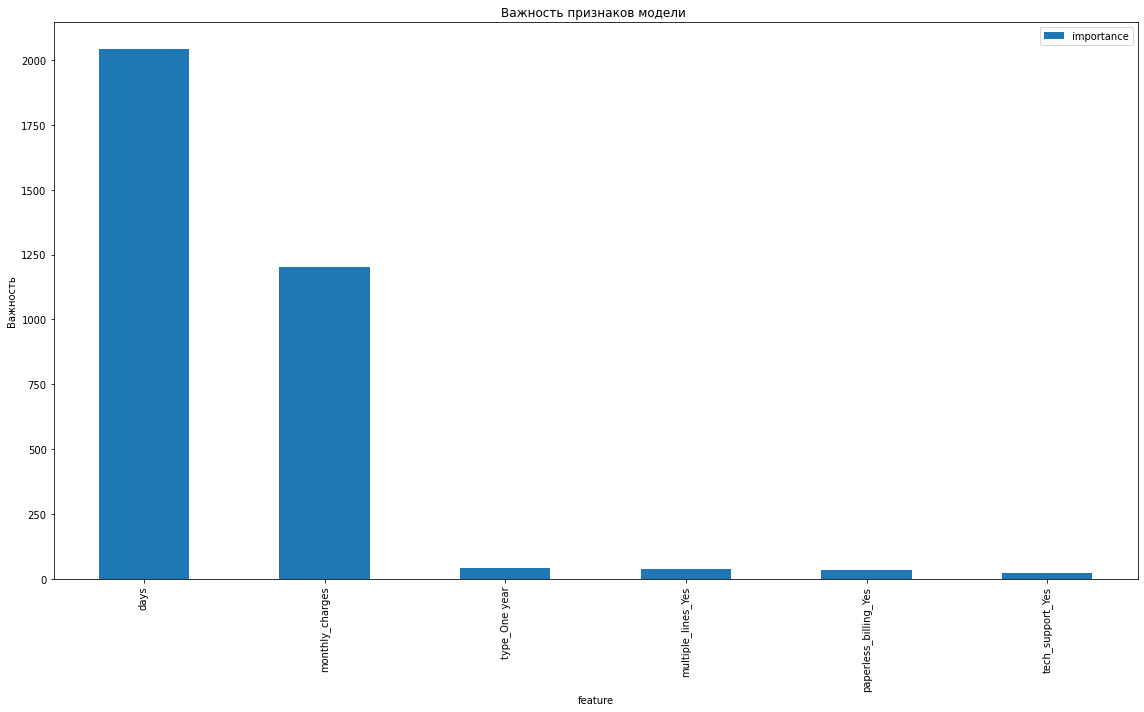

In [152]:
importance(model)

Стало немного лучше. 

### Удаление маловажных фичей 2

In [153]:
features = features[['monthly_charges', 'days']]
target = df['churn']

In [154]:
features

,monthly_charges,days
0,29.85,31
1,56.95,1036
2,53.85,61
3,42.30,1371
4,70.70,61
...,...,...
7004,84.80,730
7005,103.20,2191
7006,29.60,337
7007,74.40,123


In [155]:
features_train, features_test, target_train, target_test = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

In [156]:
features_train.shape, features_test.shape, 

((5607, 2), (1402, 2))

In [157]:
target_train.mean(), target_test.mean()

(0.2655609060103442, 0.2653352353780314)

In [158]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head(10)) 

      monthly_charges      days
2613         0.466521  1.564370
5846        -0.312023 -0.355689
2029         0.184319 -1.292270
1462         0.288900 -0.393206
1783         0.433321 -0.844748
550          1.678326  1.601887
4293        -0.479684 -0.434742
3600        -0.497944  0.911845
3789         0.964523  1.154365
5526         1.090684 -1.210537


/tmp/ipykernel_134/3159239522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_134/3159239522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

AUC-ROC лучшей модели на тестовой выборке 0.9232122350976093
Accuracy лучшей модели на тестовой выборке 0.833808844507846
F1 лучшей модели на тестовой выборке: 0.7189384800965019


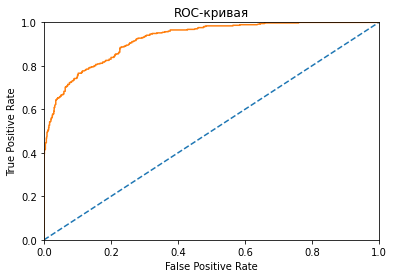

In [160]:
auc_roc_new(model, features_train, target_train,  features_test, target_test)

In [159]:
#функция для AUC-ROC и графика
def auc_roc_new(model, features_train, target_train, features_test, target_test):
    
    model.fit(features_train, target_train)
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    predicted_test = model.predict(features_test)
     
    auc_roc_model = roc_auc_score(target_test, probabilities_one_test)
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    
    print(f'AUC-ROC лучшей модели на тестовой выборке {auc_roc_model}') 
    print(f'Accuracy лучшей модели на тестовой выборке {accuracy}') 
    print(f'F1 лучшей модели на тестовой выборке: {f1}')
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    %matplotlib inline
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.show() 

importance(model)

### Вывод

Видим, что с двумя признаками модель работает немного хуже, чем с шестью, но даже чуть лучше, чем с 22 признаками. 
Много признаков засоряют эфир =)

## Вывод

В результате проекта, нам удалось построить модель, которая определяет факт ухода клиента. ROC-AUC = 0.92. f1 = 0.74

С учетом того, что с большой долей вероятности клиент, имеющий оптоволоконный интернет уйдет, оператору связи стоит задуматьмя либо над уменьшением стоимости услуг, либо над повышением их качества. 
Ну и, конечно, рассылка промо-предложенией и акций спасет мир. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
ОК, Антонина, скажу, что уверенная и качественная работа, на мой взгляд)<br>
Обработка данных, размышления над факторами, многогранная интересная модельная работа!!!!, конечные результаты, графика - многое удалось как надо. Можно сказать, что пройден весь алгоритм моделирования от анализа исходной инфо до анализа важности факторов.<br> 
А что совсем хорошо, так это то, что не стала гнаться за точностью любой ценой, даже ценой наружения бизнес-логики. (это я про даты-признаки - всегда есть соблазн их оставить...)<br>

Прежде, чем идти дальше, напомню из прошлых наших общений основные моменты, которые бы мне хотелось зафиксировать, как важные для момделирования (что-то ты и так хорошо используешь):<br>   
1) F1, Акураси и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" 
    
2) При анализе факторов влияния (их зависиомть между собой и на целевую) происходит по одному из трёх алгоритмов, исходя из типа шкалы. Могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
Это я к тому разделу, который посвящён анализу данных. Там ты сделал интересные предположения и чтобы их доказать, стои проверить аналитически. Вот как раз те методы проверки гипотез, что выше написал.<br>
    
3) Алгоритм нахождения модели может быть таким:<br>
- изучаем проблематику бизнеса и самой темы (в данном случае отток). Пытаемся понять суть явления.<br>
- генерируем разные факторы влияния - любые.<br>
- дизайнируем (прикидываем модели) какие методы решения есть, чтобы решить проблему.<br>
- Смотрим, какие данные и в какой шкале есть. Что нужно ещё, что применить выбранный метод.<br>
- Оцениваем мультиколлинеарность.<br>
- строим модели и анализируем те фактры, какие сгенерировали ранее.<br>
- Думаем над тем, какие причины (факторы) могут ещё влиять на отток.<br>
- если после нескольких итераций точность "замирает" - значит достигли потолка)<br>
 
4) Проведение анализа важности факторов с помощью команды feature_importances_ (+графический анализ). Отличная вещь намечается: высока я метрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала. Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента.<br><br><br>


Постарался отвтеить на твои вопросы. Если что пропустил, то не по злому умыслу - обязательно пиши ещё<br>
БУДУ ЖДАТЬ.

### Вывод 2
В результате корректировок удалось несущественно изменить метрику качества. 
Убрав неважные признаки, модель стала работать лучше, а важность признаков не исчезла. 

<div class="alert alert-info" style="border-color: green; border-radius: 5px">
        <p><u><b> КОММЕНТАРИЙ СТУДЕНТА 2</b></u></p> СПАСИИИИИИИБОООО!!!
</div>